# Image Classification using CNN (Tensor Flow Library)
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
#import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


#tests.test_folder_path(cifar10_dataset_folder_path)

## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [3]:
# Load labels from the dataset
def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
# Defining a helper function for loading a batch of images
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [5]:
#Defining a function to show the stats for batch ans specific sample
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 6:
Image - Min Value: 30 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


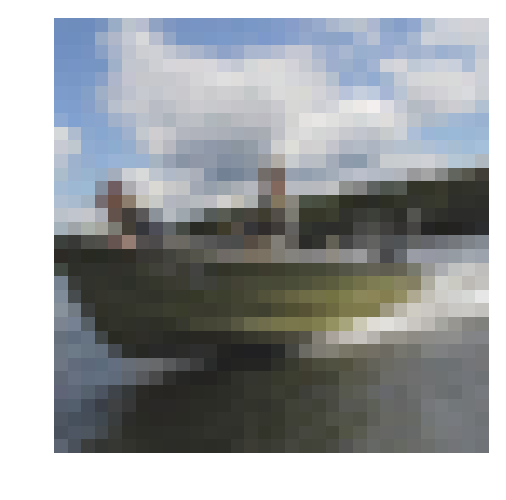

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore a specific batch and sample from the dataset
batch_id = 3
sample_id = 6
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

### Apply normalization and One-hot encoding to dataset

#### Normalize

In the cell below, implement the normalize function to take in image data, x, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive. The return object should be the same shape as x.


In [7]:
#Function used to normalize CIFAR-10 images to be in the range of [0,1]
def normalize(images):        
    # initial zero ndarray    
    normalized_images = np.zeros_like(images.astype(float))        
    
    # The first images index is number of images where the other indices indicates    
    # hieight, width and depth of the image    
    num_images = images.shape[0]        
    
    # Computing the minimum and maximum value of the input image to do the normalization based on them    
    maximum_value, minimum_value = images.max(), images.min()        
    
    # Normalize all the pixel values of the images to be from 0 to 1    
    for img in range(num_images):        
        normalized_images[img,...] = (images[img, ...] - float(minimum_value)) / float(maximum_value - minimum_value)    
    return normalized_images

### One-hot encoding
Just like the previous code cell, we'll be implementing a function for preprocessing.  This time, we'll implement the `one_hot_encode` function. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`. We will save the map of encodings outside the function.

In [8]:
# encoding the input images. Each image will be represented by a vector of zeros except for the class index of the image 
# that this vector represents. The length of this vector depends on number of classes that we have
# the dataset which is 10 in CIFAR-10

from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(images):        
    num_classes = 10        
    
    #use sklearn helper function of OneHotEncoder() to do that     
    encoder = OneHotEncoder(num_classes)        
    
    #resize the input images to be 2D    
    input_images_resized_to_2d = np.array(images).reshape(-1,1)    
    one_hot_encoded_targets = encoder.fit_transform(input_images_resized_to_2d)
    
    return one_hot_encoded_targets.toarray()

In [9]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')

In [10]:
# Call function for preprocessing of the data
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [11]:
# Load the Preprocessed Validation data
valid_input_features, valid_input_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Model Building

#### Build the network

For the neural network, we'll build each layer into a function. Most of the code we've seen has been outside of functions. To test the code more thoroughly, we would require to put each layer in a function. 

We'll have the option to use TensorFlow Layers or TensorFlow Layers (contrib) to build each layer, except "Convolutional & Max Pooling" layer. TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

Input

The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
•Implement neural_net_image_input 
◾Return a TF Placeholder
◾Set the shape using image_shape with batch size set to None.
◾Name the TensorFlow placeholder "x" using the TensorFlow name parameter in the TF Placeholder.

•Implement neural_net_label_input 
◾Return a TF Placeholder
◾Set the shape using n_classes with batch size set to None.
◾Name the TensorFlow placeholder "y" using the TensorFlow name parameter in the TF Placeholder.

•Implement neural_net_keep_prob_input 
◾Return a TF Placeholder for dropout keep probability.
◾Name the TensorFlow placeholder "keep_prob" using the TensorFlow name parameter in the TF Placeholder.


These names will be used at the end of the project to load your saved model.

Note: None for shapes in TensorFlow allow for a dynamic size.


In [12]:
# Defining the model inputs
def images_input(img_shape): 
    return tf.placeholder(tf.float32, (None, ) + img_shape, name="input_images")

def target_input(num_classes):  
    target_input = tf.placeholder(tf.int32, (None, num_classes), name="input_images_target") 
    return target_input

#define a function for the dropout layer keep probability
def keep_prob_input(): 
    return tf.placeholder(tf.float32, name="keep_prob")

In [13]:
# Applying a convolution operation to the input tensor followed by max pooling
def conv2d_layer(input_tensor, conv_layer_num_outputs, conv_kernel_size, conv_layer_strides, pool_kernel_size, pool_layer_strides): 
    input_depth = input_tensor.get_shape()[3].value 
    weight_shape = conv_kernel_size + (input_depth, conv_layer_num_outputs,)   
    
    #Defining layer weights and biases 
    weights = tf.Variable(tf.random_normal(weight_shape)) 
    biases = tf.Variable(tf.random_normal((conv_layer_num_outputs,)))  
    
    #Considering the biase variable 
    conv_strides = (1,) + conv_layer_strides + (1,)
    
    conv_layer = tf.nn.conv2d(input_tensor, weights, strides=conv_strides, padding='SAME') 
    conv_layer = tf.nn.bias_add(conv_layer, biases) 
    
    conv_kernel_size = (1,) + conv_kernel_size + (1,) 
    
    pool_strides = (1,) + pool_layer_strides + (1,) 
    pool_layer = tf.nn.max_pool(conv_layer, ksize=conv_kernel_size, strides=pool_strides, padding='SAME') 
    
    return pool_layer

In [14]:
#Flatten the output of max pooling layer to be fing to the fully connected layer which only accepts the output
# to be in 2D
def flatten_layer(input_tensor):
    return tf.contrib.layers.flatten(input_tensor)

In [15]:
#Define the fully connected layer that will use the flattened output of the stacked convolution layers
#to do the actuall classification
def fully_connected_layer(input_tensor, num_outputs): 
    return tf.layers.dense(input_tensor, num_outputs)

In [16]:
#Defining the output function
def output_layer(input_tensor, num_outputs):    
    return  tf.layers.dense(input_tensor, num_outputs)

In [17]:
def build_convolution_net(image_data, keep_prob):  
    # Applying 3 convolution layers followed by max pooling layers 
    conv_layer_1 = conv2d_layer(image_data, 32, (3,3), (1,1), (3,3), (3,3))  
    conv_layer_2 = conv2d_layer(conv_layer_1, 64, (3,3), (1,1), (3,3), (3,3)) 
    conv_layer_3 = conv2d_layer(conv_layer_2, 128, (3,3), (1,1), (3,3), (3,3))
    
    # Flatten the output from 4D to 2D to be fed to the fully connected layer 
    flatten_output = flatten_layer(conv_layer_3)
    
    # Applying 2 fully connected layers with drop out 
    fully_connected_layer_1 = fully_connected_layer(flatten_output, 64) 
    fully_connected_layer_1 = tf.nn.dropout(fully_connected_layer_1, keep_prob) 
    fully_connected_layer_2 = fully_connected_layer(fully_connected_layer_1, 32) 
    fully_connected_layer_2 = tf.nn.dropout(fully_connected_layer_2, keep_prob)  
    
    #Applying the output layer while the output size will be the number of categories that we have 
    #in CIFAR-10 dataset 
    output_logits = output_layer(fully_connected_layer_2, 10)
    
    #returning output 
    return output_logits

In [18]:
def test_conv_net(conv_net):
    test_x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    test_k = tf.placeholder(tf.float32)

    logits_out = conv_net(test_x, test_k)

    assert logits_out.get_shape().as_list() == [None, 10],\
        'Incorrect Model Output.  Found {}'.format(logits_out.get_shape().as_list())

    print('Neural Network Built!')

In [19]:
import pickle
import sys
import os
import time
import numpy as np
import glob
#import cv2

In [20]:
#import tensorflow as tf

In [22]:
#Using the helper function above to build the network
#First off, let's remove all the previous inputs, weights, biases form the previous runs
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

# Defining the input placeholders to the convolution neural network
input_images = images_input((32, 32, 3))
input_images_target = target_input(10)
keep_prob = keep_prob_input()

# Building the models
logits_values = build_convolution_net(input_images, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits_values = tf.identity(logits_values, name='logits')

# defining the model loss
model_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_values, labels=input_images_target))

# Defining the model optimizer
model_optimizer = tf.train.AdamOptimizer().minimize(model_cost)

# Calculating and averaging the model accuracy
correct_prediction = tf.equal(tf.argmax(logits_values, 1), tf.argmax(input_images_target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='model_accuracy')

C:\Users\skhaldar\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [23]:
test_conv_net(build_convolution_net)

Neural Network Built!


## Training the CNN Model

In [24]:
#Define a helper function for kicking off the training process
def train(session, model_optimizer, keep_probability, in_feature_batch, target_batch):
    session.run(model_optimizer, feed_dict={input_images: in_feature_batch, input_images_target: target_batch, keep_prob: keep_probability})

In [25]:
#Defining a helper funcitno for print information about the model accuracy and it's validation accuracy as well
def print_model_stats(session, input_feature_batch, target_label_batch, model_cost, model_accuracy):        
    validation_loss = session.run(model_cost, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})    
    validation_accuracy = session.run(model_accuracy, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})        
    
    print("Valid Loss: %f" %(validation_loss))    
    print("Valid accuracy: %f" % (validation_accuracy))

In [26]:
# Model Hyperparameters
num_epochs = 100
batch_size = 128
keep_probability = 0.5

In [27]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [28]:
print('Training on only a Single Batch from the CIFAR-10 Dataset...')
with tf.Session() as sess:  
    # Initializing the variables 
    sess.run(tf.global_variables_initializer())  
    # Training cycle 
    for epoch in range(num_epochs): 
        batch_ind = 1  
        for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size): 
            train(sess, model_optimizer, keep_probability, batch_features, batch_labels)  
            
            print('Epoch number {:>2}, CIFAR-10 Batch Number {}: '.format(epoch + 1, batch_ind), end='') 
            print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)

Training on only a Single Batch from the CIFAR-10 Dataset...
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 2368.668945
Valid accuracy: 0.171875
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1559.459595
Valid accuracy: 0.164062
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1782.790161
Valid accuracy: 0.117188
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1958.344604
Valid accuracy: 0.078125
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1996.706787
Valid accuracy: 0.078125
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 2152.405762
Valid accuracy: 0.093750
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1256.072144
Valid accuracy: 0.085938
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 897.478027
Valid accuracy: 0.140625
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 970.902039
Valid accuracy: 0.140625
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 885.077209
Valid accuracy: 0.148438
Epoch number  1, CIFAR-10 Batch 

Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 134.719620
Valid accuracy: 0.359375
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 144.900040
Valid accuracy: 0.335938
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 130.093506
Valid accuracy: 0.367188
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 147.079132
Valid accuracy: 0.382812
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 104.475662
Valid accuracy: 0.445312
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 133.332397
Valid accuracy: 0.351562
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 138.505493
Valid accuracy: 0.351562
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 123.034782
Valid accuracy: 0.359375
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 127.659142
Valid accuracy: 0.335938
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 136.029938
Valid accuracy: 0.257812
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 112.542664
Valid accuracy: 0.421875
Epoch numb

Valid accuracy: 0.453125
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 63.547050
Valid accuracy: 0.382812
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 66.948700
Valid accuracy: 0.437500
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 72.216141
Valid accuracy: 0.406250
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 66.840149
Valid accuracy: 0.359375
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 67.488876
Valid accuracy: 0.375000
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 57.250793
Valid accuracy: 0.429688
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 77.111191
Valid accuracy: 0.382812
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 68.274612
Valid accuracy: 0.414062
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 69.038055
Valid accuracy: 0.367188
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 56.293129
Valid accuracy: 0.429688
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 66.219376
Valid accuracy: 0.390

Valid accuracy: 0.500000
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 35.536301
Valid accuracy: 0.476562
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 38.169647
Valid accuracy: 0.492188
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 45.412773
Valid accuracy: 0.390625
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 32.672581
Valid accuracy: 0.523438
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 35.329060
Valid accuracy: 0.468750
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 39.912491
Valid accuracy: 0.460938
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 46.106865
Valid accuracy: 0.351562
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 39.915443
Valid accuracy: 0.476562
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 44.104256
Valid accuracy: 0.343750
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 35.694328
Valid accuracy: 0.453125
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 37.269165
Valid accuracy: 0.453

Valid accuracy: 0.414062
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 22.089703
Valid accuracy: 0.453125
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 24.705006
Valid accuracy: 0.453125
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 19.962086
Valid accuracy: 0.476562
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 27.848669
Valid accuracy: 0.429688
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 24.335699
Valid accuracy: 0.492188
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 23.008007
Valid accuracy: 0.437500
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 23.950768
Valid accuracy: 0.453125
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 20.885197
Valid accuracy: 0.492188
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 23.386374
Valid accuracy: 0.453125
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 22.280561
Valid accuracy: 0.437500
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 18.217356
Valid accuracy: 0.445

Valid accuracy: 0.437500
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 13.961370
Valid accuracy: 0.429688
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 12.913683
Valid accuracy: 0.484375
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 16.976974
Valid accuracy: 0.445312
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 13.157035
Valid accuracy: 0.453125
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 15.295899
Valid accuracy: 0.437500
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 17.061241
Valid accuracy: 0.460938
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 14.116239
Valid accuracy: 0.500000
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 12.944672
Valid accuracy: 0.453125
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 13.309627
Valid accuracy: 0.476562
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 14.525222
Valid accuracy: 0.382812
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 16.005604
Valid accuracy: 0.445

Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 9.272938
Valid accuracy: 0.445312
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 10.411007
Valid accuracy: 0.460938
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 10.735889
Valid accuracy: 0.437500
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 8.071390
Valid accuracy: 0.445312
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 8.437375
Valid accuracy: 0.414062
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 7.533533
Valid accuracy: 0.421875
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 11.194815
Valid accuracy: 0.429688
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 9.616623
Valid accuracy: 0.468750
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 6.198820
Valid accuracy: 0.500000
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 9.332739
Valid accuracy: 0.453125
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 8.808372
Valid accuracy: 0.453125
Epoch number 16, CIFAR-10 Bat

Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 9.737760
Valid accuracy: 0.328125
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 8.564032
Valid accuracy: 0.492188
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 9.800786
Valid accuracy: 0.304688
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 7.908368
Valid accuracy: 0.421875
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 8.229940
Valid accuracy: 0.421875
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 7.738557
Valid accuracy: 0.359375
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 6.929839
Valid accuracy: 0.414062
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 6.246315
Valid accuracy: 0.414062
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 5.818661
Valid accuracy: 0.445312
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 8.077410
Valid accuracy: 0.460938
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 6.235120
Valid accuracy: 0.414062
Epoch number 17, CIFAR-10 Batch 

Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 4.648319
Valid accuracy: 0.429688
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 3.161258
Valid accuracy: 0.421875
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 3.943879
Valid accuracy: 0.382812
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 4.679314
Valid accuracy: 0.351562
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 3.176701
Valid accuracy: 0.406250
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 5.135423
Valid accuracy: 0.390625
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 5.666113
Valid accuracy: 0.351562
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 5.988800
Valid accuracy: 0.359375
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 3.616865
Valid accuracy: 0.398438
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 3.974255
Valid accuracy: 0.414062
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 3.204750
Valid accuracy: 0.367188
Epoch number 20, CIFAR-10 Batch 

Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 3.991646
Valid accuracy: 0.312500
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 3.612460
Valid accuracy: 0.335938
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 3.330016
Valid accuracy: 0.343750
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 3.576479
Valid accuracy: 0.351562
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 2.561174
Valid accuracy: 0.445312
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 2.630707
Valid accuracy: 0.390625
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 3.642939
Valid accuracy: 0.398438
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 2.799880
Valid accuracy: 0.382812
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 2.818487
Valid accuracy: 0.375000
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 2.702343
Valid accuracy: 0.375000
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 3.066231
Valid accuracy: 0.445312
Epoch number 23, CIFAR-10 Batch 

Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 1.762359
Valid accuracy: 0.437500
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 2.102851
Valid accuracy: 0.343750
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 2.034023
Valid accuracy: 0.476562
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 2.172526
Valid accuracy: 0.359375
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 2.133206
Valid accuracy: 0.367188
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 2.399118
Valid accuracy: 0.429688
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 2.753457
Valid accuracy: 0.351562
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 2.085726
Valid accuracy: 0.453125
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 1.927433
Valid accuracy: 0.367188
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 2.053958
Valid accuracy: 0.382812
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 2.674608
Valid accuracy: 0.359375
Epoch number 25, CIFAR-10 Batch 

Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.903367
Valid accuracy: 0.406250
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.861462
Valid accuracy: 0.390625
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.894706
Valid accuracy: 0.468750
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.941210
Valid accuracy: 0.445312
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.832788
Valid accuracy: 0.343750
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.896593
Valid accuracy: 0.359375
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.910681
Valid accuracy: 0.359375
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.736354
Valid accuracy: 0.398438
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.753096
Valid accuracy: 0.421875
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.602629
Valid accuracy: 0.414062
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 2.068792
Valid accuracy: 0.320312
Epoch number 28, CIFAR-10 Batch 

Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.663527
Valid accuracy: 0.421875
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.641479
Valid accuracy: 0.382812
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.650076
Valid accuracy: 0.414062
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.676865
Valid accuracy: 0.390625
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.769612
Valid accuracy: 0.320312
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.708705
Valid accuracy: 0.406250
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.701157
Valid accuracy: 0.400000
Epoch number 31, CIFAR-10 Batch Number 1: Valid Loss: 1.631969
Valid accuracy: 0.406250
Epoch number 31, CIFAR-10 Batch Number 1: Valid Loss: 1.595346
Valid accuracy: 0.390625
Epoch number 31, CIFAR-10 Batch Number 1: Valid Loss: 1.675464
Valid accuracy: 0.390625
Epoch number 31, CIFAR-10 Batch Number 1: Valid Loss: 1.685512
Valid accuracy: 0.375000
Epoch number 31, CIFAR-10 Batch 

Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.711645
Valid accuracy: 0.375000
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.667470
Valid accuracy: 0.437500
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.656629
Valid accuracy: 0.343750
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.714035
Valid accuracy: 0.296875
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.643735
Valid accuracy: 0.421875
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.718223
Valid accuracy: 0.335938
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.572854
Valid accuracy: 0.398438
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.646614
Valid accuracy: 0.429688
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.637038
Valid accuracy: 0.429688
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.524549
Valid accuracy: 0.453125
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.585369
Valid accuracy: 0.390625
Epoch number 33, CIFAR-10 Batch 

Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.703988
Valid accuracy: 0.328125
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.673140
Valid accuracy: 0.351562
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.782321
Valid accuracy: 0.343750
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.593416
Valid accuracy: 0.429688
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.732933
Valid accuracy: 0.335938
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.769077
Valid accuracy: 0.343750
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.648450
Valid accuracy: 0.429688
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.675462
Valid accuracy: 0.375000
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.604067
Valid accuracy: 0.414062
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.598837
Valid accuracy: 0.382812
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.621943
Valid accuracy: 0.359375
Epoch number 36, CIFAR-10 Batch 

Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.550121
Valid accuracy: 0.500000
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.593921
Valid accuracy: 0.367188
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.649717
Valid accuracy: 0.359375
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.680048
Valid accuracy: 0.367188
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.611364
Valid accuracy: 0.398438
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.729907
Valid accuracy: 0.359375
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.689327
Valid accuracy: 0.351562
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.719129
Valid accuracy: 0.320312
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.661764
Valid accuracy: 0.406250
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.601624
Valid accuracy: 0.437500
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.614286
Valid accuracy: 0.437500
Epoch number 38, CIFAR-10 Batch 

Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.587154
Valid accuracy: 0.460938
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.588147
Valid accuracy: 0.460938
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.575647
Valid accuracy: 0.414062
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.705001
Valid accuracy: 0.414062
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.580628
Valid accuracy: 0.421875
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.623243
Valid accuracy: 0.460938
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.685130
Valid accuracy: 0.351562
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.537641
Valid accuracy: 0.445312
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.653563
Valid accuracy: 0.367188
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.698604
Valid accuracy: 0.421875
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.672134
Valid accuracy: 0.375000
Epoch number 41, CIFAR-10 Batch 

Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.583611
Valid accuracy: 0.429688
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.561823
Valid accuracy: 0.453125
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.633712
Valid accuracy: 0.375000
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.624899
Valid accuracy: 0.375000
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.616224
Valid accuracy: 0.421875
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.718903
Valid accuracy: 0.304688
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.708387
Valid accuracy: 0.359375
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.511561
Valid accuracy: 0.476562
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.595459
Valid accuracy: 0.367188
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.626006
Valid accuracy: 0.406250
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.710994
Valid accuracy: 0.343750
Epoch number 44, CIFAR-10 Batch 

Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.648947
Valid accuracy: 0.414062
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.582482
Valid accuracy: 0.398438
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.540295
Valid accuracy: 0.453125
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.631686
Valid accuracy: 0.367188
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.639588
Valid accuracy: 0.359375
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.605424
Valid accuracy: 0.421875
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.583141
Valid accuracy: 0.468750
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.571471
Valid accuracy: 0.445312
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.619567
Valid accuracy: 0.468750
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.710636
Valid accuracy: 0.359375
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.480135
Valid accuracy: 0.476562
Epoch number 46, CIFAR-10 Batch 

Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.634357
Valid accuracy: 0.453125
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.584214
Valid accuracy: 0.429688
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.611068
Valid accuracy: 0.398438
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.668884
Valid accuracy: 0.367188
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.745418
Valid accuracy: 0.414062
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.631556
Valid accuracy: 0.398438
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.580805
Valid accuracy: 0.445312
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.591490
Valid accuracy: 0.398438
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.764071
Valid accuracy: 0.320312
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.668998
Valid accuracy: 0.406250
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.651947
Valid accuracy: 0.367188
Epoch number 49, CIFAR-10 Batch 

Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.686328
Valid accuracy: 0.351562
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.620615
Valid accuracy: 0.406250
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.616596
Valid accuracy: 0.398438
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.622586
Valid accuracy: 0.367188
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.550269
Valid accuracy: 0.421875
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.630084
Valid accuracy: 0.304688
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.609898
Valid accuracy: 0.429688
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.718382
Valid accuracy: 0.375000
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.648670
Valid accuracy: 0.367188
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.636428
Valid accuracy: 0.500000
Epoch number 52, CIFAR-10 Batch Number 1: Valid Loss: 1.642862
Valid accuracy: 0.351562
Epoch number 52, CIFAR-10 Batch 

Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.563496
Valid accuracy: 0.421875
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.544863
Valid accuracy: 0.398438
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.674398
Valid accuracy: 0.390625
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.614045
Valid accuracy: 0.429688
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.540987
Valid accuracy: 0.468750
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.612208
Valid accuracy: 0.382812
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.707846
Valid accuracy: 0.328125
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.599732
Valid accuracy: 0.460938
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.633197
Valid accuracy: 0.406250
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.519640
Valid accuracy: 0.492188
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.656413
Valid accuracy: 0.382812
Epoch number 54, CIFAR-10 Batch 

Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.493482
Valid accuracy: 0.507812
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.531305
Valid accuracy: 0.382812
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.572368
Valid accuracy: 0.445312
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.685566
Valid accuracy: 0.343750
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.680468
Valid accuracy: 0.359375
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.706017
Valid accuracy: 0.390625
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.560283
Valid accuracy: 0.382812
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.656827
Valid accuracy: 0.429688
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.799369
Valid accuracy: 0.367188
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.576120
Valid accuracy: 0.468750
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.590694
Valid accuracy: 0.421875
Epoch number 57, CIFAR-10 Batch 

Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.556597
Valid accuracy: 0.437500
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.523830
Valid accuracy: 0.515625
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.712883
Valid accuracy: 0.367188
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.445329
Valid accuracy: 0.515625
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.666923
Valid accuracy: 0.398438
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.550368
Valid accuracy: 0.382812
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.607559
Valid accuracy: 0.328125
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.540333
Valid accuracy: 0.406250
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.674430
Valid accuracy: 0.398438
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.671799
Valid accuracy: 0.335938
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.654210
Valid accuracy: 0.429688
Epoch number 59, CIFAR-10 Batch 

Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.532743
Valid accuracy: 0.445312
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.662955
Valid accuracy: 0.429688
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.591824
Valid accuracy: 0.421875
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.541155
Valid accuracy: 0.484375
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.559140
Valid accuracy: 0.476562
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.563684
Valid accuracy: 0.421875
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.633103
Valid accuracy: 0.398438
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.496097
Valid accuracy: 0.445312
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.582794
Valid accuracy: 0.398438
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.578953
Valid accuracy: 0.390625
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.522775
Valid accuracy: 0.445312
Epoch number 62, CIFAR-10 Batch 

Epoch number 64, CIFAR-10 Batch Number 1: Valid Loss: 1.671671
Valid accuracy: 0.414062
Epoch number 64, CIFAR-10 Batch Number 1: Valid Loss: 1.673566
Valid accuracy: 0.406250
Epoch number 64, CIFAR-10 Batch Number 1: Valid Loss: 1.680665
Valid accuracy: 0.350000
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.615429
Valid accuracy: 0.390625
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.533927
Valid accuracy: 0.414062
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.612122
Valid accuracy: 0.414062
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.598027
Valid accuracy: 0.406250
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.607915
Valid accuracy: 0.375000
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.719565
Valid accuracy: 0.328125
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.713786
Valid accuracy: 0.375000
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.539395
Valid accuracy: 0.453125
Epoch number 65, CIFAR-10 Batch 

Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.529128
Valid accuracy: 0.421875
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.636452
Valid accuracy: 0.468750
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.548023
Valid accuracy: 0.437500
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.614806
Valid accuracy: 0.429688
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.565512
Valid accuracy: 0.445312
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.459188
Valid accuracy: 0.421875
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.538235
Valid accuracy: 0.351562
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.608804
Valid accuracy: 0.351562
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.568757
Valid accuracy: 0.429688
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.544563
Valid accuracy: 0.390625
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.547984
Valid accuracy: 0.437500
Epoch number 67, CIFAR-10 Batch 

Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.511689
Valid accuracy: 0.414062
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.643423
Valid accuracy: 0.390625
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.583789
Valid accuracy: 0.453125
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.600681
Valid accuracy: 0.421875
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.497800
Valid accuracy: 0.406250
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.507013
Valid accuracy: 0.414062
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.516118
Valid accuracy: 0.429688
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.627542
Valid accuracy: 0.437500
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.536227
Valid accuracy: 0.398438
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.583079
Valid accuracy: 0.468750
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.497554
Valid accuracy: 0.453125
Epoch number 70, CIFAR-10 Batch 

Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.472993
Valid accuracy: 0.460938
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.697571
Valid accuracy: 0.367188
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.672524
Valid accuracy: 0.414062
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.624290
Valid accuracy: 0.460938
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.630153
Valid accuracy: 0.414062
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.509124
Valid accuracy: 0.460938
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.586492
Valid accuracy: 0.375000
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.535419
Valid accuracy: 0.484375
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.509728
Valid accuracy: 0.484375
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.528503
Valid accuracy: 0.460938
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.644373
Valid accuracy: 0.398438
Epoch number 72, CIFAR-10 Batch 

Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.519279
Valid accuracy: 0.414062
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.533300
Valid accuracy: 0.421875
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.533608
Valid accuracy: 0.421875
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.450401
Valid accuracy: 0.460938
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.472595
Valid accuracy: 0.468750
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.614991
Valid accuracy: 0.429688
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.474897
Valid accuracy: 0.507812
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.426465
Valid accuracy: 0.460938
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.576831
Valid accuracy: 0.406250
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.612501
Valid accuracy: 0.429688
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.496997
Valid accuracy: 0.476562
Epoch number 75, CIFAR-10 Batch 

Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.481202
Valid accuracy: 0.476562
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.646739
Valid accuracy: 0.343750
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.563054
Valid accuracy: 0.414062
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.413087
Valid accuracy: 0.460938
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.470033
Valid accuracy: 0.437500
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.440508
Valid accuracy: 0.476562
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.647091
Valid accuracy: 0.390625
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.558691
Valid accuracy: 0.453125
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.564462
Valid accuracy: 0.476562
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.494408
Valid accuracy: 0.445312
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.562285
Valid accuracy: 0.453125
Epoch number 78, CIFAR-10 Batch 

Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.608135
Valid accuracy: 0.359375
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.492545
Valid accuracy: 0.429688
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.520719
Valid accuracy: 0.382812
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.563983
Valid accuracy: 0.421875
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.518361
Valid accuracy: 0.460938
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.654213
Valid accuracy: 0.367188
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.405443
Valid accuracy: 0.515625
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.533039
Valid accuracy: 0.421875
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.463078
Valid accuracy: 0.460938
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.592298
Valid accuracy: 0.382812
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.474649
Valid accuracy: 0.476562
Epoch number 80, CIFAR-10 Batch 

Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.616835
Valid accuracy: 0.460938
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.463732
Valid accuracy: 0.515625
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.561503
Valid accuracy: 0.484375
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.532676
Valid accuracy: 0.375000
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.625498
Valid accuracy: 0.437500
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.597916
Valid accuracy: 0.375000
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.509030
Valid accuracy: 0.460938
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.491659
Valid accuracy: 0.492188
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.546201
Valid accuracy: 0.359375
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.561483
Valid accuracy: 0.398438
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.469418
Valid accuracy: 0.460938
Epoch number 83, CIFAR-10 Batch 

Epoch number 85, CIFAR-10 Batch Number 1: Valid Loss: 1.491763
Valid accuracy: 0.429688
Epoch number 85, CIFAR-10 Batch Number 1: Valid Loss: 1.551174
Valid accuracy: 0.382812
Epoch number 85, CIFAR-10 Batch Number 1: Valid Loss: 1.532628
Valid accuracy: 0.414062
Epoch number 85, CIFAR-10 Batch Number 1: Valid Loss: 1.634772
Valid accuracy: 0.414062
Epoch number 85, CIFAR-10 Batch Number 1: Valid Loss: 1.666013
Valid accuracy: 0.406250
Epoch number 85, CIFAR-10 Batch Number 1: Valid Loss: 1.434353
Valid accuracy: 0.525000
Epoch number 86, CIFAR-10 Batch Number 1: Valid Loss: 1.507072
Valid accuracy: 0.484375
Epoch number 86, CIFAR-10 Batch Number 1: Valid Loss: 1.439833
Valid accuracy: 0.507812
Epoch number 86, CIFAR-10 Batch Number 1: Valid Loss: 1.573980
Valid accuracy: 0.406250
Epoch number 86, CIFAR-10 Batch Number 1: Valid Loss: 1.573345
Valid accuracy: 0.382812
Epoch number 86, CIFAR-10 Batch Number 1: Valid Loss: 1.455396
Valid accuracy: 0.460938
Epoch number 86, CIFAR-10 Batch 

Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.477532
Valid accuracy: 0.484375
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.514767
Valid accuracy: 0.445312
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.583655
Valid accuracy: 0.460938
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.465055
Valid accuracy: 0.484375
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.547737
Valid accuracy: 0.484375
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.419348
Valid accuracy: 0.507812
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.517399
Valid accuracy: 0.460938
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.503104
Valid accuracy: 0.453125
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.386864
Valid accuracy: 0.523438
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.493271
Valid accuracy: 0.421875
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.487716
Valid accuracy: 0.398438
Epoch number 88, CIFAR-10 Batch 

Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.514899
Valid accuracy: 0.460938
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.566965
Valid accuracy: 0.468750
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.404292
Valid accuracy: 0.468750
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.539103
Valid accuracy: 0.429688
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.628809
Valid accuracy: 0.398438
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.485741
Valid accuracy: 0.468750
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.512373
Valid accuracy: 0.468750
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.454460
Valid accuracy: 0.437500
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.543258
Valid accuracy: 0.421875
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.482291
Valid accuracy: 0.445312
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.667256
Valid accuracy: 0.351562
Epoch number 91, CIFAR-10 Batch 

Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.478500
Valid accuracy: 0.421875
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.466978
Valid accuracy: 0.460938
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.557022
Valid accuracy: 0.398438
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.427685
Valid accuracy: 0.484375
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.575112
Valid accuracy: 0.398438
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.595599
Valid accuracy: 0.382812
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.552677
Valid accuracy: 0.460938
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.538514
Valid accuracy: 0.507812
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.430861
Valid accuracy: 0.406250
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.523826
Valid accuracy: 0.421875
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.405282
Valid accuracy: 0.523438
Epoch number 93, CIFAR-10 Batch 

Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.436839
Valid accuracy: 0.523438
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.506936
Valid accuracy: 0.445312
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.567470
Valid accuracy: 0.406250
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.387674
Valid accuracy: 0.476562
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.535889
Valid accuracy: 0.421875
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.522015
Valid accuracy: 0.382812
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.389321
Valid accuracy: 0.523438
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.437749
Valid accuracy: 0.468750
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.591594
Valid accuracy: 0.421875
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.528504
Valid accuracy: 0.445312
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.436627
Valid accuracy: 0.460938
Epoch number 96, CIFAR-10 Batch 

Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.427699
Valid accuracy: 0.468750
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.577560
Valid accuracy: 0.375000
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.518663
Valid accuracy: 0.453125
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.449972
Valid accuracy: 0.460938
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.589283
Valid accuracy: 0.437500
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.584648
Valid accuracy: 0.406250
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.372148
Valid accuracy: 0.507812
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.467560
Valid accuracy: 0.460938
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.448957
Valid accuracy: 0.476562
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.652161
Valid accuracy: 0.328125
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.507848
Valid accuracy: 0.429688
Epoch number 99, CIFAR-10 Batch 

In [29]:
model_save_path = './cifar-10_classification'

with tf.Session() as sess: 
    # Initializing the variables 
    sess.run(tf.global_variables_initializer())  
    
    # Training cycle 
    for epoch in range(num_epochs):  
        # iterate through the batches 
        num_batches = 5  
        for batch_ind in range(1, num_batches + 1): 
            for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size): 
                train(sess, model_optimizer, keep_probability, batch_features, batch_labels)  
                print('Epoch number{:>2}, CIFAR-10 Batch Number {}: '.format(epoch + 1, batch_ind), end='') 
                print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)  
                
    # Save the trained Model 
    saver = tf.train.Saver() 
    save_path = saver.save(sess, model_save_path)

Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1748.797363
Valid accuracy: 0.117188
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1439.479126
Valid accuracy: 0.085938
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1143.218628
Valid accuracy: 0.148438
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1358.539551
Valid accuracy: 0.156250
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1315.583252
Valid accuracy: 0.156250
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 999.145142
Valid accuracy: 0.132812
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 994.651306
Valid accuracy: 0.078125
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 939.142456
Valid accuracy: 0.085938
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 852.395203
Valid accuracy: 0.132812
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 712.045898
Valid accuracy: 0.203125
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 760.269531
Valid accuracy: 0.164062
Epoch number 1, 

Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 241.835114
Valid accuracy: 0.281250
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 214.466690
Valid accuracy: 0.281250
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 244.904205
Valid accuracy: 0.289062
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 256.750793
Valid accuracy: 0.250000
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 220.824890
Valid accuracy: 0.273438
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 251.143280
Valid accuracy: 0.273438
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 248.930939
Valid accuracy: 0.296875
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 192.617432
Valid accuracy: 0.367188
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 232.821716
Valid accuracy: 0.273438
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 232.504700
Valid accuracy: 0.242188
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 249.985001
Valid accuracy: 0.265625
Epoch number 1, CIFAR

Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 94.578537
Valid accuracy: 0.296875
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 74.694534
Valid accuracy: 0.359375
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 123.178085
Valid accuracy: 0.296875
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 78.171539
Valid accuracy: 0.453125
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 102.783997
Valid accuracy: 0.289062
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 82.057953
Valid accuracy: 0.390625
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 78.871941
Valid accuracy: 0.421875
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 83.845810
Valid accuracy: 0.425000
Epoch number 1, CIFAR-10 Batch Number 5: Valid Loss: 71.706520
Valid accuracy: 0.406250
Epoch number 1, CIFAR-10 Batch Number 5: Valid Loss: 108.669083
Valid accuracy: 0.359375
Epoch number 1, CIFAR-10 Batch Number 5: Valid Loss: 92.642853
Valid accuracy: 0.351562
Epoch number 1, CIFAR-10 Batc

Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 59.218338
Valid accuracy: 0.429688
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 82.008965
Valid accuracy: 0.320312
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 63.571739
Valid accuracy: 0.476562
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 59.865524
Valid accuracy: 0.359375
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 57.316383
Valid accuracy: 0.390625
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 75.232712
Valid accuracy: 0.289062
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 68.064270
Valid accuracy: 0.375000
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 58.025593
Valid accuracy: 0.445312
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 61.097366
Valid accuracy: 0.382812
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 69.487076
Valid accuracy: 0.328125
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 57.982170
Valid accuracy: 0.375000
Epoch number 2, CIFAR-10 Batch N

Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 35.363190
Valid accuracy: 0.359375
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 26.626015
Valid accuracy: 0.468750
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 36.569550
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 34.294987
Valid accuracy: 0.390625
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 31.005138
Valid accuracy: 0.429688
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 37.693020
Valid accuracy: 0.359375
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 32.991379
Valid accuracy: 0.421875
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 29.362244
Valid accuracy: 0.390625
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 33.140930
Valid accuracy: 0.437500
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 29.291504
Valid accuracy: 0.390625
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 30.297523
Valid accuracy: 0.429688
Epoch number 2, CIFAR-10 Batch N

Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 17.647108
Valid accuracy: 0.445312
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 16.864895
Valid accuracy: 0.421875
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 23.746326
Valid accuracy: 0.359375
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 17.174416
Valid accuracy: 0.437500
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 19.355373
Valid accuracy: 0.414062
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 17.962463
Valid accuracy: 0.429688
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 21.999813
Valid accuracy: 0.398438
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 19.944881
Valid accuracy: 0.460938
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 18.963696
Valid accuracy: 0.382812
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 22.710766
Valid accuracy: 0.398438
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 19.127415
Valid accuracy: 0.414062
Epoch number 3, CIFAR-10 Batch N

Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 13.032417
Valid accuracy: 0.398438
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 11.981718
Valid accuracy: 0.382812
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 11.655393
Valid accuracy: 0.375000
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 9.829758
Valid accuracy: 0.406250
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 10.744854
Valid accuracy: 0.468750
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 12.313328
Valid accuracy: 0.429688
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 12.245676
Valid accuracy: 0.406250
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 13.162592
Valid accuracy: 0.367188
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 11.640516
Valid accuracy: 0.429688
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 14.009062
Valid accuracy: 0.476562
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 13.985938
Valid accuracy: 0.312500
Epoch number 3, CIFAR-10 Batch Nu

Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 6.858366
Valid accuracy: 0.429688
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 6.220965
Valid accuracy: 0.390625
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 5.931254
Valid accuracy: 0.390625
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 6.016920
Valid accuracy: 0.468750
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 7.329026
Valid accuracy: 0.382812
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 4.622538
Valid accuracy: 0.539062
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 3.920965
Valid accuracy: 0.406250
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 4.966705
Valid accuracy: 0.437500
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 6.424855
Valid accuracy: 0.312500
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 6.206446
Valid accuracy: 0.429688
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 8.779819
Valid accuracy: 0.296875
Epoch number 4, CIFAR-10 Batch Number 1: Va

Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 3.559279
Valid accuracy: 0.320312
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 3.986071
Valid accuracy: 0.351562
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 4.429192
Valid accuracy: 0.335938
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 4.696490
Valid accuracy: 0.265625
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 3.437408
Valid accuracy: 0.343750
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 3.280687
Valid accuracy: 0.414062
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 3.637212
Valid accuracy: 0.304688
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 4.686392
Valid accuracy: 0.312500
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 3.008681
Valid accuracy: 0.375000
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 3.839700
Valid accuracy: 0.351562
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 4.220667
Valid accuracy: 0.328125
Epoch number 4, CIFAR-10 Batch Number 4: Va

Epoch number 5, CIFAR-10 Batch Number 1: Valid Loss: 3.690882
Valid accuracy: 0.250000
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 2.693563
Valid accuracy: 0.351562
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 3.202601
Valid accuracy: 0.242188
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 2.894843
Valid accuracy: 0.296875
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 2.674752
Valid accuracy: 0.281250
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 2.833059
Valid accuracy: 0.335938
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 2.569481
Valid accuracy: 0.351562
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 2.381951
Valid accuracy: 0.351562
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 2.558423
Valid accuracy: 0.304688
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 2.304306
Valid accuracy: 0.328125
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 2.371655
Valid accuracy: 0.281250
Epoch number 5, CIFAR-10 Batch Number 2: Va

Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 2.171752
Valid accuracy: 0.375000
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 2.168071
Valid accuracy: 0.296875
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 2.083154
Valid accuracy: 0.343750
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 2.381456
Valid accuracy: 0.343750
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.923553
Valid accuracy: 0.421875
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.923001
Valid accuracy: 0.375000
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 2.016954
Valid accuracy: 0.312500
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.821162
Valid accuracy: 0.367188
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.878187
Valid accuracy: 0.375000
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 2.169302
Valid accuracy: 0.367188
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 2.006788
Valid accuracy: 0.320312
Epoch number 5, CIFAR-10 Batch Number 4: Va

Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.708729
Valid accuracy: 0.367188
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.854332
Valid accuracy: 0.351562
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.727609
Valid accuracy: 0.367188
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.869408
Valid accuracy: 0.367188
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.717381
Valid accuracy: 0.445312
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.756656
Valid accuracy: 0.312500
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.788611
Valid accuracy: 0.414062
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.908131
Valid accuracy: 0.281250
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.843765
Valid accuracy: 0.382812
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.767784
Valid accuracy: 0.320312
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.665484
Valid accuracy: 0.335938
Epoch number 6, CIFAR-10 Batch Number 2: Va

Epoch number 6, CIFAR-10 Batch Number 4: Valid Loss: 1.738502
Valid accuracy: 0.296875
Epoch number 6, CIFAR-10 Batch Number 4: Valid Loss: 1.736413
Valid accuracy: 0.335938
Epoch number 6, CIFAR-10 Batch Number 4: Valid Loss: 1.725992
Valid accuracy: 0.335938
Epoch number 6, CIFAR-10 Batch Number 4: Valid Loss: 1.626657
Valid accuracy: 0.406250
Epoch number 6, CIFAR-10 Batch Number 4: Valid Loss: 1.684433
Valid accuracy: 0.325000
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.690965
Valid accuracy: 0.406250
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.920573
Valid accuracy: 0.242188
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.708362
Valid accuracy: 0.304688
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.743078
Valid accuracy: 0.281250
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.755064
Valid accuracy: 0.343750
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.652826
Valid accuracy: 0.476562
Epoch number 6, CIFAR-10 Batch Number 5: Va

Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.792297
Valid accuracy: 0.296875
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.743807
Valid accuracy: 0.312500
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.769610
Valid accuracy: 0.328125
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.710666
Valid accuracy: 0.375000
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.707828
Valid accuracy: 0.406250
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.816022
Valid accuracy: 0.359375
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.675087
Valid accuracy: 0.390625
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.783818
Valid accuracy: 0.304688
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.691251
Valid accuracy: 0.390625
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.736807
Valid accuracy: 0.296875
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.780331
Valid accuracy: 0.390625
Epoch number 7, CIFAR-10 Batch Number 2: Va

Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.742085
Valid accuracy: 0.382812
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.679934
Valid accuracy: 0.398438
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.632310
Valid accuracy: 0.382812
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.710627
Valid accuracy: 0.382812
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.695576
Valid accuracy: 0.390625
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.812963
Valid accuracy: 0.273438
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.776146
Valid accuracy: 0.351562
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.744545
Valid accuracy: 0.328125
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.621168
Valid accuracy: 0.414062
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.828994
Valid accuracy: 0.273438
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.766543
Valid accuracy: 0.382812
Epoch number 7, CIFAR-10 Batch Number 5: Va

Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.722101
Valid accuracy: 0.351562
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.692985
Valid accuracy: 0.429688
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.689799
Valid accuracy: 0.359375
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.766062
Valid accuracy: 0.343750
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.723536
Valid accuracy: 0.390625
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.545634
Valid accuracy: 0.406250
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.592317
Valid accuracy: 0.453125
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.700939
Valid accuracy: 0.406250
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.635230
Valid accuracy: 0.425000
Epoch number 8, CIFAR-10 Batch Number 3: Valid Loss: 1.796101
Valid accuracy: 0.367188
Epoch number 8, CIFAR-10 Batch Number 3: Valid Loss: 1.780689
Valid accuracy: 0.320312
Epoch number 8, CIFAR-10 Batch Number 3: Va

Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.714502
Valid accuracy: 0.382812
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.699043
Valid accuracy: 0.296875
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.670201
Valid accuracy: 0.343750
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.708985
Valid accuracy: 0.367188
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.683432
Valid accuracy: 0.382812
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.677795
Valid accuracy: 0.414062
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.623609
Valid accuracy: 0.367188
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.681512
Valid accuracy: 0.398438
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.754950
Valid accuracy: 0.375000
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.751243
Valid accuracy: 0.328125
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.683804
Valid accuracy: 0.398438
Epoch number 8, CIFAR-10 Batch Number 5: Va

Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.656258
Valid accuracy: 0.359375
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.734414
Valid accuracy: 0.328125
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.656741
Valid accuracy: 0.367188
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.648604
Valid accuracy: 0.414062
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.641814
Valid accuracy: 0.375000
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.711230
Valid accuracy: 0.359375
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.696197
Valid accuracy: 0.429688
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.647826
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.708666
Valid accuracy: 0.382812
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.704317
Valid accuracy: 0.375000
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.712289
Valid accuracy: 0.382812
Epoch number 9, CIFAR-10 Batch Number 3: Va

Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.685396
Valid accuracy: 0.406250
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.597205
Valid accuracy: 0.468750
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.639510
Valid accuracy: 0.343750
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.754244
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.737092
Valid accuracy: 0.328125
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.664920
Valid accuracy: 0.390625
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.640549
Valid accuracy: 0.390625
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.663125
Valid accuracy: 0.414062
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.718895
Valid accuracy: 0.414062
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.620616
Valid accuracy: 0.414062
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.800353
Valid accuracy: 0.335938
Epoch number 9, CIFAR-10 Batch Number 5: Va

Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.600228
Valid accuracy: 0.406250
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.687301
Valid accuracy: 0.460938
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.547718
Valid accuracy: 0.476562
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.566991
Valid accuracy: 0.437500
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.788691
Valid accuracy: 0.367188
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.611991
Valid accuracy: 0.453125
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.620851
Valid accuracy: 0.421875
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.612406
Valid accuracy: 0.492188
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.616392
Valid accuracy: 0.414062
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.637034
Valid accuracy: 0.375000
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.503440
Valid accuracy: 0.414062
Epoch number10, CIFAR-10 Batch Number 3: Va

Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.667826
Valid accuracy: 0.343750
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.684787
Valid accuracy: 0.335938
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.619119
Valid accuracy: 0.390625
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.707852
Valid accuracy: 0.375000
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.706641
Valid accuracy: 0.367188
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.639946
Valid accuracy: 0.406250
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.723449
Valid accuracy: 0.367188
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.862744
Valid accuracy: 0.312500
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.668599
Valid accuracy: 0.398438
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.721920
Valid accuracy: 0.320312
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.697294
Valid accuracy: 0.320312
Epoch number11, CIFAR-10 Batch Number 1: Va

Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.603638
Valid accuracy: 0.414062
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.634660
Valid accuracy: 0.406250
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.664053
Valid accuracy: 0.328125
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.616346
Valid accuracy: 0.398438
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.686156
Valid accuracy: 0.398438
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.639494
Valid accuracy: 0.375000
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.684752
Valid accuracy: 0.359375
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.762176
Valid accuracy: 0.328125
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.554542
Valid accuracy: 0.468750
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.793306
Valid accuracy: 0.289062
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.677232
Valid accuracy: 0.367188
Epoch number11, CIFAR-10 Batch Number 3: Va

Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.523655
Valid accuracy: 0.406250
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.728958
Valid accuracy: 0.375000
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.600485
Valid accuracy: 0.453125
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.688152
Valid accuracy: 0.406250
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.659826
Valid accuracy: 0.367188
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.489218
Valid accuracy: 0.460938
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.678954
Valid accuracy: 0.406250
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.660264
Valid accuracy: 0.375000
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.730684
Valid accuracy: 0.390625
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.617999
Valid accuracy: 0.406250
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.731911
Valid accuracy: 0.328125
Epoch number12, CIFAR-10 Batch Number 1: Va

Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.833365
Valid accuracy: 0.320312
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.716387
Valid accuracy: 0.328125
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.676673
Valid accuracy: 0.390625
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.609655
Valid accuracy: 0.375000
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.639703
Valid accuracy: 0.429688
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.752164
Valid accuracy: 0.343750
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.631759
Valid accuracy: 0.382812
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.668418
Valid accuracy: 0.398438
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.659042
Valid accuracy: 0.351562
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.825092
Valid accuracy: 0.328125
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.842165
Valid accuracy: 0.289062
Epoch number12, CIFAR-10 Batch Number 4: Va

Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.683660
Valid accuracy: 0.343750
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.657974
Valid accuracy: 0.421875
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.611190
Valid accuracy: 0.406250
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.678932
Valid accuracy: 0.414062
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.504595
Valid accuracy: 0.445312
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.565224
Valid accuracy: 0.390625
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.643162
Valid accuracy: 0.382812
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.725071
Valid accuracy: 0.320312
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.571161
Valid accuracy: 0.382812
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.724484
Valid accuracy: 0.367188
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.673004
Valid accuracy: 0.375000
Epoch number13, CIFAR-10 Batch Number 1: Va

Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.728476
Valid accuracy: 0.312500
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.723307
Valid accuracy: 0.398438
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.818808
Valid accuracy: 0.281250
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.804509
Valid accuracy: 0.273438
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.620989
Valid accuracy: 0.390625
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.694843
Valid accuracy: 0.312500
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.704821
Valid accuracy: 0.406250
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.664592
Valid accuracy: 0.359375
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.669863
Valid accuracy: 0.382812
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.687197
Valid accuracy: 0.375000
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.663162
Valid accuracy: 0.382812
Epoch number13, CIFAR-10 Batch Number 4: Va

Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.602817
Valid accuracy: 0.382812
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.855353
Valid accuracy: 0.335938
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.536963
Valid accuracy: 0.460938
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.725198
Valid accuracy: 0.335938
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.731311
Valid accuracy: 0.382812
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.593455
Valid accuracy: 0.437500
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.663212
Valid accuracy: 0.351562
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.708921
Valid accuracy: 0.351562
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.694029
Valid accuracy: 0.382812
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.598583
Valid accuracy: 0.429688
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.644368
Valid accuracy: 0.437500
Epoch number14, CIFAR-10 Batch Number 2: Va

Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.774801
Valid accuracy: 0.367188
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.654712
Valid accuracy: 0.375000
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.687907
Valid accuracy: 0.367188
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.551855
Valid accuracy: 0.492188
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.696949
Valid accuracy: 0.382812
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.604299
Valid accuracy: 0.445312
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.625889
Valid accuracy: 0.382812
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.531029
Valid accuracy: 0.476562
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.761482
Valid accuracy: 0.359375
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.719422
Valid accuracy: 0.367188
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.612436
Valid accuracy: 0.343750
Epoch number14, CIFAR-10 Batch Number 4: Va

Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.664284
Valid accuracy: 0.367188
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.522427
Valid accuracy: 0.390625
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.587788
Valid accuracy: 0.421875
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.600326
Valid accuracy: 0.406250
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.669051
Valid accuracy: 0.382812
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.654614
Valid accuracy: 0.406250
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.701333
Valid accuracy: 0.375000
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.656753
Valid accuracy: 0.359375
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.637762
Valid accuracy: 0.414062
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.613193
Valid accuracy: 0.390625
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.714498
Valid accuracy: 0.328125
Epoch number15, CIFAR-10 Batch Number 2: Va

Epoch number15, CIFAR-10 Batch Number 4: Valid Loss: 1.670498
Valid accuracy: 0.359375
Epoch number15, CIFAR-10 Batch Number 4: Valid Loss: 1.639426
Valid accuracy: 0.398438
Epoch number15, CIFAR-10 Batch Number 4: Valid Loss: 1.641526
Valid accuracy: 0.351562
Epoch number15, CIFAR-10 Batch Number 4: Valid Loss: 1.547220
Valid accuracy: 0.375000
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.586025
Valid accuracy: 0.398438
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.835903
Valid accuracy: 0.281250
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.671780
Valid accuracy: 0.351562
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.668690
Valid accuracy: 0.328125
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.639223
Valid accuracy: 0.359375
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.575159
Valid accuracy: 0.398438
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.659297
Valid accuracy: 0.406250
Epoch number15, CIFAR-10 Batch Number 5: Va

Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.713235
Valid accuracy: 0.351562
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.673952
Valid accuracy: 0.382812
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.680291
Valid accuracy: 0.328125
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.637048
Valid accuracy: 0.414062
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.783969
Valid accuracy: 0.382812
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.590795
Valid accuracy: 0.367188
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.676672
Valid accuracy: 0.367188
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.520193
Valid accuracy: 0.414062
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.533478
Valid accuracy: 0.390625
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.662741
Valid accuracy: 0.375000
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.600694
Valid accuracy: 0.406250
Epoch number16, CIFAR-10 Batch Number 2: Va

Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.599089
Valid accuracy: 0.382812
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.425737
Valid accuracy: 0.460938
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.577304
Valid accuracy: 0.375000
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.628895
Valid accuracy: 0.398438
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.724083
Valid accuracy: 0.328125
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.739725
Valid accuracy: 0.304688
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.593887
Valid accuracy: 0.367188
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.533979
Valid accuracy: 0.460938
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.690678
Valid accuracy: 0.367188
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.616143
Valid accuracy: 0.398438
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.716182
Valid accuracy: 0.367188
Epoch number16, CIFAR-10 Batch Number 5: Va

Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.654850
Valid accuracy: 0.375000
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.589604
Valid accuracy: 0.414062
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.646897
Valid accuracy: 0.406250
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.639529
Valid accuracy: 0.351562
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.528835
Valid accuracy: 0.429688
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.532978
Valid accuracy: 0.460938
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.628739
Valid accuracy: 0.429688
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.548927
Valid accuracy: 0.475000
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.642350
Valid accuracy: 0.460938
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.710565
Valid accuracy: 0.351562
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.718921
Valid accuracy: 0.328125
Epoch number17, CIFAR-10 Batch Number 3: Va

Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.610388
Valid accuracy: 0.312500
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.612445
Valid accuracy: 0.375000
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.652037
Valid accuracy: 0.445312
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.534491
Valid accuracy: 0.382812
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.594321
Valid accuracy: 0.351562
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.547378
Valid accuracy: 0.382812
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.584080
Valid accuracy: 0.382812
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.636250
Valid accuracy: 0.367188
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.575173
Valid accuracy: 0.367188
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.570649
Valid accuracy: 0.421875
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.492175
Valid accuracy: 0.406250
Epoch number17, CIFAR-10 Batch Number 5: Va

Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.587871
Valid accuracy: 0.429688
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.595297
Valid accuracy: 0.382812
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.629864
Valid accuracy: 0.367188
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.445472
Valid accuracy: 0.484375
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.629110
Valid accuracy: 0.406250
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.631725
Valid accuracy: 0.437500
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.550483
Valid accuracy: 0.390625
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.504407
Valid accuracy: 0.445312
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.546981
Valid accuracy: 0.421875
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.594994
Valid accuracy: 0.406250
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.700818
Valid accuracy: 0.437500
Epoch number18, CIFAR-10 Batch Number 3: Va

Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.382711
Valid accuracy: 0.460938
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.509599
Valid accuracy: 0.414062
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.688890
Valid accuracy: 0.414062
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.735009
Valid accuracy: 0.351562
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.590560
Valid accuracy: 0.421875
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.511240
Valid accuracy: 0.476562
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.615257
Valid accuracy: 0.453125
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.594952
Valid accuracy: 0.429688
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.493331
Valid accuracy: 0.468750
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.657507
Valid accuracy: 0.414062
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.470442
Valid accuracy: 0.460938
Epoch number18, CIFAR-10 Batch Number 5: Va

Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.613984
Valid accuracy: 0.429688
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.422270
Valid accuracy: 0.507812
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.443114
Valid accuracy: 0.484375
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.649966
Valid accuracy: 0.335938
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.510581
Valid accuracy: 0.460938
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.454571
Valid accuracy: 0.500000
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.460813
Valid accuracy: 0.515625
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.531095
Valid accuracy: 0.437500
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.539263
Valid accuracy: 0.429688
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.416667
Valid accuracy: 0.500000
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.519448
Valid accuracy: 0.421875
Epoch number19, CIFAR-10 Batch Number 3: Va

Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.463327
Valid accuracy: 0.515625
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.569835
Valid accuracy: 0.320312
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.601737
Valid accuracy: 0.375000
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.555643
Valid accuracy: 0.421875
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.541011
Valid accuracy: 0.375000
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.512201
Valid accuracy: 0.390625
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.765398
Valid accuracy: 0.343750
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.443255
Valid accuracy: 0.468750
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.561564
Valid accuracy: 0.437500
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.576931
Valid accuracy: 0.437500
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.604289
Valid accuracy: 0.406250
Epoch number20, CIFAR-10 Batch Number 1: Va

Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.562034
Valid accuracy: 0.382812
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.581711
Valid accuracy: 0.406250
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.515785
Valid accuracy: 0.414062
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.548356
Valid accuracy: 0.437500
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.531460
Valid accuracy: 0.460938
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.581365
Valid accuracy: 0.421875
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.673985
Valid accuracy: 0.375000
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.452945
Valid accuracy: 0.500000
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.629149
Valid accuracy: 0.429688
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.502339
Valid accuracy: 0.445312
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.478302
Valid accuracy: 0.484375
Epoch number20, CIFAR-10 Batch Number 3: Va

Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.578306
Valid accuracy: 0.367188
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.520875
Valid accuracy: 0.429688
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.563331
Valid accuracy: 0.445312
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.527839
Valid accuracy: 0.429688
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.398867
Valid accuracy: 0.500000
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.614974
Valid accuracy: 0.351562
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.538934
Valid accuracy: 0.468750
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.615024
Valid accuracy: 0.421875
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.553918
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.653802
Valid accuracy: 0.367188
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.631755
Valid accuracy: 0.390625
Epoch number21, CIFAR-10 Batch Number 1: Va

Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.581861
Valid accuracy: 0.421875
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.607720
Valid accuracy: 0.382812
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.475007
Valid accuracy: 0.500000
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.479496
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.536666
Valid accuracy: 0.437500
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.532629
Valid accuracy: 0.453125
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.529757
Valid accuracy: 0.468750
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.481777
Valid accuracy: 0.476562
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.621889
Valid accuracy: 0.375000
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.614111
Valid accuracy: 0.382812
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.451463
Valid accuracy: 0.554688
Epoch number21, CIFAR-10 Batch Number 4: Va

Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.517608
Valid accuracy: 0.484375
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.480637
Valid accuracy: 0.484375
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.579112
Valid accuracy: 0.421875
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.343441
Valid accuracy: 0.554688
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.511343
Valid accuracy: 0.398438
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.505194
Valid accuracy: 0.421875
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.544031
Valid accuracy: 0.406250
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.380719
Valid accuracy: 0.507812
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.563210
Valid accuracy: 0.437500
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.527510
Valid accuracy: 0.398438
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.536257
Valid accuracy: 0.445312
Epoch number22, CIFAR-10 Batch Number 1: Va

Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.618840
Valid accuracy: 0.390625
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.637497
Valid accuracy: 0.414062
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.611350
Valid accuracy: 0.398438
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.458761
Valid accuracy: 0.500000
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.568216
Valid accuracy: 0.414062
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.598374
Valid accuracy: 0.429688
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.472054
Valid accuracy: 0.445312
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.540801
Valid accuracy: 0.468750
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.610362
Valid accuracy: 0.429688
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.561836
Valid accuracy: 0.453125
Epoch number22, CIFAR-10 Batch Number 4: Valid Loss: 1.487355
Valid accuracy: 0.531250
Epoch number22, CIFAR-10 Batch Number 4: Va

Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.733206
Valid accuracy: 0.382812
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.392683
Valid accuracy: 0.515625
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.602627
Valid accuracy: 0.328125
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.465187
Valid accuracy: 0.437500
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.420807
Valid accuracy: 0.539062
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.416103
Valid accuracy: 0.492188
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.455462
Valid accuracy: 0.500000
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.550145
Valid accuracy: 0.429688
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.431056
Valid accuracy: 0.515625
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.466499
Valid accuracy: 0.468750
Epoch number23, CIFAR-10 Batch Number 2: Valid Loss: 1.496926
Valid accuracy: 0.484375
Epoch number23, CIFAR-10 Batch Number 2: Va

Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.430173
Valid accuracy: 0.460938
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.550008
Valid accuracy: 0.406250
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.320138
Valid accuracy: 0.554688
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.552010
Valid accuracy: 0.398438
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.437701
Valid accuracy: 0.476562
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.456099
Valid accuracy: 0.460938
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.427617
Valid accuracy: 0.515625
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.613396
Valid accuracy: 0.414062
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.622577
Valid accuracy: 0.398438
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.468587
Valid accuracy: 0.375000
Epoch number23, CIFAR-10 Batch Number 4: Valid Loss: 1.513732
Valid accuracy: 0.382812
Epoch number23, CIFAR-10 Batch Number 4: Va

Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.390404
Valid accuracy: 0.492188
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.455755
Valid accuracy: 0.492188
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.474181
Valid accuracy: 0.445312
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.487829
Valid accuracy: 0.429688
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.493648
Valid accuracy: 0.437500
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.487791
Valid accuracy: 0.406250
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.478039
Valid accuracy: 0.507812
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.539747
Valid accuracy: 0.445312
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.354742
Valid accuracy: 0.468750
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.545216
Valid accuracy: 0.359375
Epoch number24, CIFAR-10 Batch Number 2: Valid Loss: 1.497216
Valid accuracy: 0.445312
Epoch number24, CIFAR-10 Batch Number 2: Va

Epoch number24, CIFAR-10 Batch Number 4: Valid Loss: 1.404627
Valid accuracy: 0.515625
Epoch number24, CIFAR-10 Batch Number 4: Valid Loss: 1.396932
Valid accuracy: 0.468750
Epoch number24, CIFAR-10 Batch Number 4: Valid Loss: 1.420495
Valid accuracy: 0.425000
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.405985
Valid accuracy: 0.515625
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.581478
Valid accuracy: 0.382812
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.437595
Valid accuracy: 0.453125
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.502626
Valid accuracy: 0.476562
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.423701
Valid accuracy: 0.500000
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.349251
Valid accuracy: 0.523438
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.530473
Valid accuracy: 0.445312
Epoch number24, CIFAR-10 Batch Number 5: Valid Loss: 1.602657
Valid accuracy: 0.367188
Epoch number24, CIFAR-10 Batch Number 5: Va

Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.536997
Valid accuracy: 0.468750
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.486457
Valid accuracy: 0.515625
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.401068
Valid accuracy: 0.500000
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.595564
Valid accuracy: 0.460938
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.406736
Valid accuracy: 0.492188
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.499010
Valid accuracy: 0.460938
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.350624
Valid accuracy: 0.500000
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.305909
Valid accuracy: 0.523438
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.520016
Valid accuracy: 0.460938
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.425528
Valid accuracy: 0.468750
Epoch number25, CIFAR-10 Batch Number 2: Valid Loss: 1.487269
Valid accuracy: 0.429688
Epoch number25, CIFAR-10 Batch Number 2: Va

Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.255399
Valid accuracy: 0.539062
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.387502
Valid accuracy: 0.484375
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.481637
Valid accuracy: 0.492188
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.559428
Valid accuracy: 0.445312
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.523840
Valid accuracy: 0.421875
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.458782
Valid accuracy: 0.476562
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.384980
Valid accuracy: 0.523438
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.538808
Valid accuracy: 0.429688
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.414082
Valid accuracy: 0.515625
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.528550
Valid accuracy: 0.500000
Epoch number25, CIFAR-10 Batch Number 5: Valid Loss: 1.297448
Valid accuracy: 0.523438
Epoch number25, CIFAR-10 Batch Number 5: Va

Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.399933
Valid accuracy: 0.562500
Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.391858
Valid accuracy: 0.476562
Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.454447
Valid accuracy: 0.492188
Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.324343
Valid accuracy: 0.453125
Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.342800
Valid accuracy: 0.570312
Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.434236
Valid accuracy: 0.492188
Epoch number26, CIFAR-10 Batch Number 2: Valid Loss: 1.326014
Valid accuracy: 0.525000
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.456088
Valid accuracy: 0.484375
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.486166
Valid accuracy: 0.445312
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.509261
Valid accuracy: 0.437500
Epoch number26, CIFAR-10 Batch Number 3: Valid Loss: 1.431366
Valid accuracy: 0.414062
Epoch number26, CIFAR-10 Batch Number 3: Va

Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.397250
Valid accuracy: 0.453125
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.528972
Valid accuracy: 0.453125
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.399954
Valid accuracy: 0.500000
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.391747
Valid accuracy: 0.500000
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.351708
Valid accuracy: 0.515625
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.315125
Valid accuracy: 0.539062
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.474009
Valid accuracy: 0.460938
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.408980
Valid accuracy: 0.484375
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.406186
Valid accuracy: 0.492188
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.323848
Valid accuracy: 0.500000
Epoch number26, CIFAR-10 Batch Number 5: Valid Loss: 1.518640
Valid accuracy: 0.515625
Epoch number26, CIFAR-10 Batch Number 5: Va

Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.329955
Valid accuracy: 0.539062
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.400383
Valid accuracy: 0.414062
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.246401
Valid accuracy: 0.476562
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.425599
Valid accuracy: 0.531250
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.457857
Valid accuracy: 0.437500
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.362148
Valid accuracy: 0.453125
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.323758
Valid accuracy: 0.507812
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.348057
Valid accuracy: 0.484375
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.403931
Valid accuracy: 0.585938
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.482567
Valid accuracy: 0.484375
Epoch number27, CIFAR-10 Batch Number 3: Valid Loss: 1.332820
Valid accuracy: 0.531250
Epoch number27, CIFAR-10 Batch Number 3: Va

Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.301292
Valid accuracy: 0.523438
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.536408
Valid accuracy: 0.437500
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.456130
Valid accuracy: 0.460938
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.401104
Valid accuracy: 0.484375
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.342544
Valid accuracy: 0.539062
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.334695
Valid accuracy: 0.562500
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.420468
Valid accuracy: 0.531250
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.314870
Valid accuracy: 0.539062
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.467077
Valid accuracy: 0.460938
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.231714
Valid accuracy: 0.578125
Epoch number27, CIFAR-10 Batch Number 5: Valid Loss: 1.392933
Valid accuracy: 0.600000
Epoch number28, CIFAR-10 Batch Number 1: Va

Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.276025
Valid accuracy: 0.554688
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.270718
Valid accuracy: 0.585938
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.517707
Valid accuracy: 0.453125
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.227256
Valid accuracy: 0.656250
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.225133
Valid accuracy: 0.570312
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.336266
Valid accuracy: 0.539062
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.344334
Valid accuracy: 0.554688
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.326604
Valid accuracy: 0.539062
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.196389
Valid accuracy: 0.585938
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.291164
Valid accuracy: 0.500000
Epoch number28, CIFAR-10 Batch Number 3: Valid Loss: 1.392275
Valid accuracy: 0.500000
Epoch number28, CIFAR-10 Batch Number 3: Va

Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.377887
Valid accuracy: 0.523438
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.330738
Valid accuracy: 0.515625
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.330726
Valid accuracy: 0.539062
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.348525
Valid accuracy: 0.492188
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.182358
Valid accuracy: 0.632812
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.541648
Valid accuracy: 0.429688
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.233397
Valid accuracy: 0.562500
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.272471
Valid accuracy: 0.531250
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.357855
Valid accuracy: 0.515625
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.346711
Valid accuracy: 0.515625
Epoch number29, CIFAR-10 Batch Number 1: Valid Loss: 1.274597
Valid accuracy: 0.585938
Epoch number29, CIFAR-10 Batch Number 1: Va

Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.386895
Valid accuracy: 0.468750
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.309279
Valid accuracy: 0.484375
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.394742
Valid accuracy: 0.492188
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.381266
Valid accuracy: 0.460938
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.424883
Valid accuracy: 0.492188
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.491222
Valid accuracy: 0.406250
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.270289
Valid accuracy: 0.546875
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.460847
Valid accuracy: 0.476562
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.302342
Valid accuracy: 0.562500
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.297824
Valid accuracy: 0.539062
Epoch number29, CIFAR-10 Batch Number 3: Valid Loss: 1.438595
Valid accuracy: 0.476562
Epoch number29, CIFAR-10 Batch Number 3: Va

Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.319124
Valid accuracy: 0.523438
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.396816
Valid accuracy: 0.500000
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.351397
Valid accuracy: 0.531250
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.248752
Valid accuracy: 0.546875
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.375616
Valid accuracy: 0.500000
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.306222
Valid accuracy: 0.515625
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.438139
Valid accuracy: 0.492188
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.408734
Valid accuracy: 0.531250
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.462394
Valid accuracy: 0.414062
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.452659
Valid accuracy: 0.476562
Epoch number30, CIFAR-10 Batch Number 1: Valid Loss: 1.347973
Valid accuracy: 0.546875
Epoch number30, CIFAR-10 Batch Number 1: Va

Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.356617
Valid accuracy: 0.515625
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.281274
Valid accuracy: 0.500000
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.198876
Valid accuracy: 0.609375
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.312846
Valid accuracy: 0.531250
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.352063
Valid accuracy: 0.554688
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.357653
Valid accuracy: 0.492188
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.293195
Valid accuracy: 0.507812
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.404505
Valid accuracy: 0.554688
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.474925
Valid accuracy: 0.476562
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.250021
Valid accuracy: 0.609375
Epoch number30, CIFAR-10 Batch Number 4: Valid Loss: 1.297843
Valid accuracy: 0.546875
Epoch number30, CIFAR-10 Batch Number 4: Va

Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.318815
Valid accuracy: 0.531250
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.359618
Valid accuracy: 0.492188
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.114812
Valid accuracy: 0.617188
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.234845
Valid accuracy: 0.546875
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.217914
Valid accuracy: 0.539062
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.291976
Valid accuracy: 0.554688
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.176827
Valid accuracy: 0.617188
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.327208
Valid accuracy: 0.546875
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.344846
Valid accuracy: 0.500000
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.341731
Valid accuracy: 0.562500
Epoch number31, CIFAR-10 Batch Number 1: Valid Loss: 1.333149
Valid accuracy: 0.500000
Epoch number31, CIFAR-10 Batch Number 1: Va

Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.465611
Valid accuracy: 0.468750
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.397780
Valid accuracy: 0.531250
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.290538
Valid accuracy: 0.515625
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.375375
Valid accuracy: 0.492188
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.364465
Valid accuracy: 0.562500
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.236935
Valid accuracy: 0.632812
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.329048
Valid accuracy: 0.507812
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.370088
Valid accuracy: 0.492188
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.293502
Valid accuracy: 0.562500
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.297493
Valid accuracy: 0.570312
Epoch number31, CIFAR-10 Batch Number 4: Valid Loss: 1.319571
Valid accuracy: 0.531250
Epoch number31, CIFAR-10 Batch Number 4: Va

Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.252254
Valid accuracy: 0.593750
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.363864
Valid accuracy: 0.445312
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.293669
Valid accuracy: 0.539062
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.187222
Valid accuracy: 0.632812
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.156537
Valid accuracy: 0.648438
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.265199
Valid accuracy: 0.554688
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.403348
Valid accuracy: 0.421875
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.232272
Valid accuracy: 0.593750
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.266308
Valid accuracy: 0.523438
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.288439
Valid accuracy: 0.507812
Epoch number32, CIFAR-10 Batch Number 2: Valid Loss: 1.300065
Valid accuracy: 0.531250
Epoch number32, CIFAR-10 Batch Number 2: Va

Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.361423
Valid accuracy: 0.562500
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.164189
Valid accuracy: 0.625000
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.355426
Valid accuracy: 0.515625
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.242031
Valid accuracy: 0.585938
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.214902
Valid accuracy: 0.531250
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.250464
Valid accuracy: 0.578125
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.424148
Valid accuracy: 0.484375
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.445045
Valid accuracy: 0.445312
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.274897
Valid accuracy: 0.484375
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.359131
Valid accuracy: 0.492188
Epoch number32, CIFAR-10 Batch Number 4: Valid Loss: 1.321928
Valid accuracy: 0.476562
Epoch number32, CIFAR-10 Batch Number 4: Va

Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.333273
Valid accuracy: 0.546875
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.319146
Valid accuracy: 0.492188
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.326486
Valid accuracy: 0.523438
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.347686
Valid accuracy: 0.523438
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.210726
Valid accuracy: 0.546875
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.419374
Valid accuracy: 0.437500
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.365897
Valid accuracy: 0.539062
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.168969
Valid accuracy: 0.593750
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.379424
Valid accuracy: 0.476562
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.264342
Valid accuracy: 0.507812
Epoch number33, CIFAR-10 Batch Number 2: Valid Loss: 1.350691
Valid accuracy: 0.539062
Epoch number33, CIFAR-10 Batch Number 2: Va

Epoch number33, CIFAR-10 Batch Number 4: Valid Loss: 1.091879
Valid accuracy: 0.609375
Epoch number33, CIFAR-10 Batch Number 4: Valid Loss: 1.099691
Valid accuracy: 0.575000
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.187791
Valid accuracy: 0.554688
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.366952
Valid accuracy: 0.492188
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.221073
Valid accuracy: 0.539062
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.326517
Valid accuracy: 0.531250
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.287940
Valid accuracy: 0.570312
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.161949
Valid accuracy: 0.593750
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.308099
Valid accuracy: 0.531250
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.333813
Valid accuracy: 0.492188
Epoch number33, CIFAR-10 Batch Number 5: Valid Loss: 1.331677
Valid accuracy: 0.476562
Epoch number33, CIFAR-10 Batch Number 5: Va

Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.321148
Valid accuracy: 0.539062
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.228405
Valid accuracy: 0.617188
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.417140
Valid accuracy: 0.507812
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.166909
Valid accuracy: 0.601562
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.304712
Valid accuracy: 0.515625
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.139026
Valid accuracy: 0.609375
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.186733
Valid accuracy: 0.507812
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.388251
Valid accuracy: 0.515625
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.161788
Valid accuracy: 0.601562
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.334946
Valid accuracy: 0.539062
Epoch number34, CIFAR-10 Batch Number 2: Valid Loss: 1.184661
Valid accuracy: 0.617188
Epoch number34, CIFAR-10 Batch Number 2: Va

Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.248835
Valid accuracy: 0.570312
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.269023
Valid accuracy: 0.570312
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.251045
Valid accuracy: 0.562500
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.318510
Valid accuracy: 0.515625
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.266457
Valid accuracy: 0.562500
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.267279
Valid accuracy: 0.546875
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.409050
Valid accuracy: 0.515625
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.252787
Valid accuracy: 0.531250
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.291153
Valid accuracy: 0.515625
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.065591
Valid accuracy: 0.632812
Epoch number34, CIFAR-10 Batch Number 5: Valid Loss: 1.320149
Valid accuracy: 0.468750
Epoch number34, CIFAR-10 Batch Number 5: Va

Epoch number35, CIFAR-10 Batch Number 2: Valid Loss: 1.167554
Valid accuracy: 0.578125
Epoch number35, CIFAR-10 Batch Number 2: Valid Loss: 1.315336
Valid accuracy: 0.523438
Epoch number35, CIFAR-10 Batch Number 2: Valid Loss: 1.108647
Valid accuracy: 0.593750
Epoch number35, CIFAR-10 Batch Number 2: Valid Loss: 1.215002
Valid accuracy: 0.554688
Epoch number35, CIFAR-10 Batch Number 2: Valid Loss: 1.191046
Valid accuracy: 0.585938
Epoch number35, CIFAR-10 Batch Number 2: Valid Loss: 1.060249
Valid accuracy: 0.575000
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.310807
Valid accuracy: 0.593750
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.314053
Valid accuracy: 0.484375
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.397265
Valid accuracy: 0.437500
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.317045
Valid accuracy: 0.484375
Epoch number35, CIFAR-10 Batch Number 3: Valid Loss: 1.242451
Valid accuracy: 0.562500
Epoch number35, CIFAR-10 Batch Number 3: Va

Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.325173
Valid accuracy: 0.515625
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.228029
Valid accuracy: 0.531250
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.207292
Valid accuracy: 0.601562
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.151740
Valid accuracy: 0.578125
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.157566
Valid accuracy: 0.593750
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.185282
Valid accuracy: 0.609375
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.247608
Valid accuracy: 0.523438
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.220242
Valid accuracy: 0.617188
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.129882
Valid accuracy: 0.562500
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.368496
Valid accuracy: 0.562500
Epoch number35, CIFAR-10 Batch Number 5: Valid Loss: 1.237096
Valid accuracy: 0.531250
Epoch number35, CIFAR-10 Batch Number 5: Va

Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.294051
Valid accuracy: 0.531250
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.120707
Valid accuracy: 0.531250
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.223325
Valid accuracy: 0.515625
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.242898
Valid accuracy: 0.562500
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.244914
Valid accuracy: 0.531250
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.240557
Valid accuracy: 0.515625
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.265583
Valid accuracy: 0.500000
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.252823
Valid accuracy: 0.546875
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.350148
Valid accuracy: 0.539062
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.236630
Valid accuracy: 0.578125
Epoch number36, CIFAR-10 Batch Number 3: Valid Loss: 1.262560
Valid accuracy: 0.554688
Epoch number36, CIFAR-10 Batch Number 3: Va

Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.380562
Valid accuracy: 0.523438
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.257846
Valid accuracy: 0.515625
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.185919
Valid accuracy: 0.539062
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.157466
Valid accuracy: 0.617188
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.102851
Valid accuracy: 0.632812
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.222446
Valid accuracy: 0.578125
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.025131
Valid accuracy: 0.625000
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.296259
Valid accuracy: 0.554688
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.139308
Valid accuracy: 0.539062
Epoch number36, CIFAR-10 Batch Number 5: Valid Loss: 1.132874
Valid accuracy: 0.650000
Epoch number37, CIFAR-10 Batch Number 1: Valid Loss: 1.139659
Valid accuracy: 0.554688
Epoch number37, CIFAR-10 Batch Number 1: Va

Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.143852
Valid accuracy: 0.578125
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.314015
Valid accuracy: 0.492188
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.066027
Valid accuracy: 0.617188
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.095143
Valid accuracy: 0.648438
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.196452
Valid accuracy: 0.601562
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.193626
Valid accuracy: 0.632812
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.213326
Valid accuracy: 0.601562
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.024430
Valid accuracy: 0.640625
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.176467
Valid accuracy: 0.585938
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.146197
Valid accuracy: 0.578125
Epoch number37, CIFAR-10 Batch Number 3: Valid Loss: 1.080296
Valid accuracy: 0.625000
Epoch number37, CIFAR-10 Batch Number 3: Va

Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.259235
Valid accuracy: 0.546875
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.230482
Valid accuracy: 0.554688
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.219021
Valid accuracy: 0.539062
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.077312
Valid accuracy: 0.593750
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.305885
Valid accuracy: 0.531250
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.116131
Valid accuracy: 0.570312
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.129453
Valid accuracy: 0.601562
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.241288
Valid accuracy: 0.562500
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.214275
Valid accuracy: 0.570312
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.065403
Valid accuracy: 0.648438
Epoch number38, CIFAR-10 Batch Number 1: Valid Loss: 1.186983
Valid accuracy: 0.601562
Epoch number38, CIFAR-10 Batch Number 1: Va

Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.116062
Valid accuracy: 0.570312
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.197322
Valid accuracy: 0.531250
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.218601
Valid accuracy: 0.523438
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.245569
Valid accuracy: 0.570312
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.277563
Valid accuracy: 0.585938
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.137965
Valid accuracy: 0.585938
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.293814
Valid accuracy: 0.523438
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.050271
Valid accuracy: 0.585938
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.179727
Valid accuracy: 0.640625
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.232372
Valid accuracy: 0.554688
Epoch number38, CIFAR-10 Batch Number 3: Valid Loss: 1.189103
Valid accuracy: 0.570312
Epoch number38, CIFAR-10 Batch Number 3: Va

Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.272625
Valid accuracy: 0.484375
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.114126
Valid accuracy: 0.570312
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.102097
Valid accuracy: 0.585938
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.150741
Valid accuracy: 0.609375
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.149577
Valid accuracy: 0.570312
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.231441
Valid accuracy: 0.593750
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.203968
Valid accuracy: 0.539062
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.244298
Valid accuracy: 0.554688
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.241960
Valid accuracy: 0.531250
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.265543
Valid accuracy: 0.562500
Epoch number39, CIFAR-10 Batch Number 1: Valid Loss: 1.253143
Valid accuracy: 0.570312
Epoch number39, CIFAR-10 Batch Number 1: Va

Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.016849
Valid accuracy: 0.640625
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.004643
Valid accuracy: 0.632812
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.130258
Valid accuracy: 0.570312
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.156818
Valid accuracy: 0.531250
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.164314
Valid accuracy: 0.601562
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.113762
Valid accuracy: 0.593750
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.216478
Valid accuracy: 0.546875
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.287944
Valid accuracy: 0.546875
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.064016
Valid accuracy: 0.648438
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.152862
Valid accuracy: 0.539062
Epoch number39, CIFAR-10 Batch Number 4: Valid Loss: 1.214094
Valid accuracy: 0.578125
Epoch number39, CIFAR-10 Batch Number 4: Va

Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.222722
Valid accuracy: 0.570312
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.036267
Valid accuracy: 0.609375
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.214842
Valid accuracy: 0.531250
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.040539
Valid accuracy: 0.625000
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.116423
Valid accuracy: 0.562500
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.014674
Valid accuracy: 0.679688
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.180555
Valid accuracy: 0.539062
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.209042
Valid accuracy: 0.546875
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.240859
Valid accuracy: 0.539062
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.185511
Valid accuracy: 0.593750
Epoch number40, CIFAR-10 Batch Number 1: Valid Loss: 1.015491
Valid accuracy: 0.640625
Epoch number40, CIFAR-10 Batch Number 1: Va

Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.250973
Valid accuracy: 0.531250
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.101532
Valid accuracy: 0.625000
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.191144
Valid accuracy: 0.531250
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.212255
Valid accuracy: 0.593750
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.118088
Valid accuracy: 0.609375
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.105927
Valid accuracy: 0.617188
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.193423
Valid accuracy: 0.546875
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.133739
Valid accuracy: 0.625000
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.151170
Valid accuracy: 0.648438
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.111966
Valid accuracy: 0.570312
Epoch number40, CIFAR-10 Batch Number 4: Valid Loss: 1.177374
Valid accuracy: 0.515625
Epoch number40, CIFAR-10 Batch Number 4: Va

Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.231132
Valid accuracy: 0.531250
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.114993
Valid accuracy: 0.593750
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.018791
Valid accuracy: 0.632812
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.020540
Valid accuracy: 0.640625
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.131902
Valid accuracy: 0.585938
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.248144
Valid accuracy: 0.523438
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.026347
Valid accuracy: 0.632812
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.141160
Valid accuracy: 0.554688
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.129749
Valid accuracy: 0.570312
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.152159
Valid accuracy: 0.570312
Epoch number41, CIFAR-10 Batch Number 2: Valid Loss: 1.175789
Valid accuracy: 0.585938
Epoch number41, CIFAR-10 Batch Number 2: Va

Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.048827
Valid accuracy: 0.648438
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.215229
Valid accuracy: 0.546875
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.063925
Valid accuracy: 0.625000
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.097253
Valid accuracy: 0.570312
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.033230
Valid accuracy: 0.625000
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.316492
Valid accuracy: 0.539062
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.249227
Valid accuracy: 0.562500
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.114587
Valid accuracy: 0.585938
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.262684
Valid accuracy: 0.531250
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.132011
Valid accuracy: 0.539062
Epoch number41, CIFAR-10 Batch Number 4: Valid Loss: 1.175351
Valid accuracy: 0.531250
Epoch number41, CIFAR-10 Batch Number 4: Va

Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.137678
Valid accuracy: 0.570312
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.175195
Valid accuracy: 0.632812
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.125885
Valid accuracy: 0.632812
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.012040
Valid accuracy: 0.617188
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.168795
Valid accuracy: 0.554688
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.139551
Valid accuracy: 0.625000
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.003061
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.199029
Valid accuracy: 0.500000
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.104694
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.130654
Valid accuracy: 0.593750
Epoch number42, CIFAR-10 Batch Number 2: Valid Loss: 1.141017
Valid accuracy: 0.593750
Epoch number42, CIFAR-10 Batch Number 2: Va

Epoch number42, CIFAR-10 Batch Number 4: Valid Loss: 0.901980
Valid accuracy: 0.650000
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.043562
Valid accuracy: 0.593750
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.173879
Valid accuracy: 0.562500
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.105801
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.168498
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.143530
Valid accuracy: 0.585938
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 0.930369
Valid accuracy: 0.671875
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.197717
Valid accuracy: 0.500000
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.168533
Valid accuracy: 0.539062
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.164279
Valid accuracy: 0.546875
Epoch number42, CIFAR-10 Batch Number 5: Valid Loss: 1.145001
Valid accuracy: 0.570312
Epoch number42, CIFAR-10 Batch Number 5: Va

Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.043889
Valid accuracy: 0.671875
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.275137
Valid accuracy: 0.539062
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.023357
Valid accuracy: 0.632812
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.137413
Valid accuracy: 0.593750
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.048610
Valid accuracy: 0.585938
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.127970
Valid accuracy: 0.554688
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.243983
Valid accuracy: 0.562500
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 0.976400
Valid accuracy: 0.671875
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.241851
Valid accuracy: 0.570312
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.078166
Valid accuracy: 0.585938
Epoch number43, CIFAR-10 Batch Number 2: Valid Loss: 1.078156
Valid accuracy: 0.625000
Epoch number43, CIFAR-10 Batch Number 2: Va

Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.226385
Valid accuracy: 0.578125
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.072989
Valid accuracy: 0.601562
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.170803
Valid accuracy: 0.562500
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.157536
Valid accuracy: 0.585938
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.089110
Valid accuracy: 0.601562
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.250772
Valid accuracy: 0.531250
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.059477
Valid accuracy: 0.562500
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.132622
Valid accuracy: 0.578125
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 0.873449
Valid accuracy: 0.687500
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.161456
Valid accuracy: 0.570312
Epoch number43, CIFAR-10 Batch Number 5: Valid Loss: 1.119369
Valid accuracy: 0.562500
Epoch number43, CIFAR-10 Batch Number 5: Va

Epoch number44, CIFAR-10 Batch Number 2: Valid Loss: 1.151122
Valid accuracy: 0.609375
Epoch number44, CIFAR-10 Batch Number 2: Valid Loss: 1.011096
Valid accuracy: 0.640625
Epoch number44, CIFAR-10 Batch Number 2: Valid Loss: 1.095450
Valid accuracy: 0.656250
Epoch number44, CIFAR-10 Batch Number 2: Valid Loss: 1.064079
Valid accuracy: 0.679688
Epoch number44, CIFAR-10 Batch Number 2: Valid Loss: 0.921949
Valid accuracy: 0.650000
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 1.156535
Valid accuracy: 0.578125
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 1.109023
Valid accuracy: 0.570312
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 1.173243
Valid accuracy: 0.578125
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 1.095647
Valid accuracy: 0.570312
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 1.015102
Valid accuracy: 0.703125
Epoch number44, CIFAR-10 Batch Number 3: Valid Loss: 1.028327
Valid accuracy: 0.625000
Epoch number44, CIFAR-10 Batch Number 3: Va

Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.048490
Valid accuracy: 0.656250
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.031995
Valid accuracy: 0.687500
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.007417
Valid accuracy: 0.656250
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.035593
Valid accuracy: 0.593750
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 0.987912
Valid accuracy: 0.664062
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.137403
Valid accuracy: 0.570312
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.041861
Valid accuracy: 0.664062
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 0.936084
Valid accuracy: 0.695312
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.159257
Valid accuracy: 0.593750
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.122074
Valid accuracy: 0.578125
Epoch number44, CIFAR-10 Batch Number 5: Valid Loss: 1.102530
Valid accuracy: 0.593750
Epoch number44, CIFAR-10 Batch Number 5: Va

Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 0.993835
Valid accuracy: 0.640625
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.113716
Valid accuracy: 0.578125
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.039778
Valid accuracy: 0.640625
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.066837
Valid accuracy: 0.617188
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.071110
Valid accuracy: 0.578125
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.058601
Valid accuracy: 0.609375
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.071645
Valid accuracy: 0.640625
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.157717
Valid accuracy: 0.562500
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.064352
Valid accuracy: 0.648438
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 1.032538
Valid accuracy: 0.562500
Epoch number45, CIFAR-10 Batch Number 3: Valid Loss: 0.983961
Valid accuracy: 0.664062
Epoch number45, CIFAR-10 Batch Number 3: Va

Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 1.074650
Valid accuracy: 0.625000
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 0.996069
Valid accuracy: 0.679688
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 1.024591
Valid accuracy: 0.648438
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 0.897210
Valid accuracy: 0.726562
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 1.022390
Valid accuracy: 0.640625
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 0.852822
Valid accuracy: 0.734375
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 1.164581
Valid accuracy: 0.578125
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 0.953547
Valid accuracy: 0.648438
Epoch number45, CIFAR-10 Batch Number 5: Valid Loss: 0.860188
Valid accuracy: 0.675000
Epoch number46, CIFAR-10 Batch Number 1: Valid Loss: 0.998540
Valid accuracy: 0.664062
Epoch number46, CIFAR-10 Batch Number 1: Valid Loss: 0.985625
Valid accuracy: 0.742188
Epoch number46, CIFAR-10 Batch Number 1: Va

Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 1.163375
Valid accuracy: 0.601562
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.927927
Valid accuracy: 0.648438
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.902987
Valid accuracy: 0.671875
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 1.045663
Valid accuracy: 0.640625
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 1.026623
Valid accuracy: 0.664062
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 1.043911
Valid accuracy: 0.632812
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.934000
Valid accuracy: 0.710938
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 1.043484
Valid accuracy: 0.632812
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.932741
Valid accuracy: 0.679688
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.965438
Valid accuracy: 0.578125
Epoch number46, CIFAR-10 Batch Number 3: Valid Loss: 0.965103
Valid accuracy: 0.656250
Epoch number46, CIFAR-10 Batch Number 3: Va

Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 1.076517
Valid accuracy: 0.601562
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 1.082397
Valid accuracy: 0.609375
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.847358
Valid accuracy: 0.726562
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 1.180695
Valid accuracy: 0.578125
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.952869
Valid accuracy: 0.640625
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.963602
Valid accuracy: 0.687500
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 1.077932
Valid accuracy: 0.578125
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.994745
Valid accuracy: 0.640625
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.890157
Valid accuracy: 0.671875
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 1.108889
Valid accuracy: 0.656250
Epoch number47, CIFAR-10 Batch Number 1: Valid Loss: 0.976695
Valid accuracy: 0.671875
Epoch number47, CIFAR-10 Batch Number 1: Va

Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.041691
Valid accuracy: 0.593750
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.023435
Valid accuracy: 0.617188
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.069504
Valid accuracy: 0.632812
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.044167
Valid accuracy: 0.695312
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 0.994358
Valid accuracy: 0.664062
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.145159
Valid accuracy: 0.601562
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 0.954404
Valid accuracy: 0.710938
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.065314
Valid accuracy: 0.648438
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.071174
Valid accuracy: 0.632812
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.017865
Valid accuracy: 0.632812
Epoch number47, CIFAR-10 Batch Number 3: Valid Loss: 1.103327
Valid accuracy: 0.585938
Epoch number47, CIFAR-10 Batch Number 3: Va

Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.974604
Valid accuracy: 0.632812
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 1.005817
Valid accuracy: 0.664062
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.958167
Valid accuracy: 0.648438
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.985976
Valid accuracy: 0.617188
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 1.083238
Valid accuracy: 0.656250
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 1.095444
Valid accuracy: 0.625000
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 1.084147
Valid accuracy: 0.625000
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 1.145781
Valid accuracy: 0.554688
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 1.098203
Valid accuracy: 0.632812
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 1.154095
Valid accuracy: 0.562500
Epoch number48, CIFAR-10 Batch Number 1: Valid Loss: 0.986633
Valid accuracy: 0.656250
Epoch number48, CIFAR-10 Batch Number 1: Va

Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.894812
Valid accuracy: 0.695312
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.991515
Valid accuracy: 0.617188
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.973422
Valid accuracy: 0.679688
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.101521
Valid accuracy: 0.609375
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.013429
Valid accuracy: 0.640625
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.022626
Valid accuracy: 0.656250
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.111196
Valid accuracy: 0.570312
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.989377
Valid accuracy: 0.671875
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.071106
Valid accuracy: 0.570312
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 0.957746
Valid accuracy: 0.648438
Epoch number48, CIFAR-10 Batch Number 4: Valid Loss: 1.222970
Valid accuracy: 0.523438
Epoch number48, CIFAR-10 Batch Number 4: Va

Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.848501
Valid accuracy: 0.687500
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 1.092957
Valid accuracy: 0.617188
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.895225
Valid accuracy: 0.734375
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 1.021899
Valid accuracy: 0.671875
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.872598
Valid accuracy: 0.726562
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 1.065395
Valid accuracy: 0.578125
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 1.112704
Valid accuracy: 0.585938
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 1.034137
Valid accuracy: 0.609375
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 1.005295
Valid accuracy: 0.617188
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 0.924170
Valid accuracy: 0.679688
Epoch number49, CIFAR-10 Batch Number 1: Valid Loss: 1.029114
Valid accuracy: 0.632812
Epoch number49, CIFAR-10 Batch Number 1: Va

Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.984283
Valid accuracy: 0.671875
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 1.019524
Valid accuracy: 0.617188
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 1.008455
Valid accuracy: 0.656250
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.889615
Valid accuracy: 0.695312
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.886854
Valid accuracy: 0.687500
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 1.035154
Valid accuracy: 0.632812
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.998497
Valid accuracy: 0.625000
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.997375
Valid accuracy: 0.625000
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.936519
Valid accuracy: 0.656250
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 1.021094
Valid accuracy: 0.617188
Epoch number49, CIFAR-10 Batch Number 4: Valid Loss: 0.902989
Valid accuracy: 0.679688
Epoch number49, CIFAR-10 Batch Number 4: Va

Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 1.016969
Valid accuracy: 0.640625
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.897524
Valid accuracy: 0.710938
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.904530
Valid accuracy: 0.703125
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.968096
Valid accuracy: 0.617188
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 1.077765
Valid accuracy: 0.593750
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.903885
Valid accuracy: 0.679688
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 1.037888
Valid accuracy: 0.585938
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 1.104962
Valid accuracy: 0.601562
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 1.034800
Valid accuracy: 0.578125
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 1.028981
Valid accuracy: 0.593750
Epoch number50, CIFAR-10 Batch Number 2: Valid Loss: 0.999200
Valid accuracy: 0.648438
Epoch number50, CIFAR-10 Batch Number 2: Va

Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 1.075090
Valid accuracy: 0.609375
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.861547
Valid accuracy: 0.671875
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.983574
Valid accuracy: 0.601562
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.907403
Valid accuracy: 0.687500
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 1.186476
Valid accuracy: 0.609375
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 1.077310
Valid accuracy: 0.617188
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.997435
Valid accuracy: 0.593750
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 1.095403
Valid accuracy: 0.609375
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.982470
Valid accuracy: 0.671875
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.972543
Valid accuracy: 0.648438
Epoch number50, CIFAR-10 Batch Number 4: Valid Loss: 0.998739
Valid accuracy: 0.585938
Epoch number50, CIFAR-10 Batch Number 4: Va

Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 1.090540
Valid accuracy: 0.585938
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 0.989567
Valid accuracy: 0.632812
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 0.942378
Valid accuracy: 0.625000
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 1.082854
Valid accuracy: 0.609375
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 1.184169
Valid accuracy: 0.562500
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 0.935802
Valid accuracy: 0.656250
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 1.045810
Valid accuracy: 0.601562
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 0.978150
Valid accuracy: 0.656250
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 1.068320
Valid accuracy: 0.578125
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 1.000342
Valid accuracy: 0.617188
Epoch number51, CIFAR-10 Batch Number 2: Valid Loss: 0.958547
Valid accuracy: 0.640625
Epoch number51, CIFAR-10 Batch Number 2: Va

Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 0.896553
Valid accuracy: 0.640625
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 1.089869
Valid accuracy: 0.617188
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 0.970619
Valid accuracy: 0.664062
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 1.021397
Valid accuracy: 0.617188
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 1.023714
Valid accuracy: 0.640625
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 0.827177
Valid accuracy: 0.703125
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 1.040348
Valid accuracy: 0.593750
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 1.045215
Valid accuracy: 0.632812
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 1.067284
Valid accuracy: 0.601562
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 0.946564
Valid accuracy: 0.687500
Epoch number51, CIFAR-10 Batch Number 5: Valid Loss: 1.073660
Valid accuracy: 0.671875
Epoch number51, CIFAR-10 Batch Number 5: Va

Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 1.152449
Valid accuracy: 0.593750
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.880783
Valid accuracy: 0.687500
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 1.013014
Valid accuracy: 0.617188
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.930749
Valid accuracy: 0.679688
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.948505
Valid accuracy: 0.664062
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 1.057917
Valid accuracy: 0.617188
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.876843
Valid accuracy: 0.687500
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 1.136810
Valid accuracy: 0.609375
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.898399
Valid accuracy: 0.710938
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.967399
Valid accuracy: 0.625000
Epoch number52, CIFAR-10 Batch Number 2: Valid Loss: 0.955294
Valid accuracy: 0.640625
Epoch number52, CIFAR-10 Batch Number 2: Va

Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 0.947643
Valid accuracy: 0.664062
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 1.094150
Valid accuracy: 0.593750
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 1.083938
Valid accuracy: 0.585938
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 0.981082
Valid accuracy: 0.609375
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 1.125868
Valid accuracy: 0.570312
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 0.899216
Valid accuracy: 0.648438
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 1.019269
Valid accuracy: 0.617188
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 0.759322
Valid accuracy: 0.742188
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 1.045864
Valid accuracy: 0.617188
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 0.984744
Valid accuracy: 0.625000
Epoch number52, CIFAR-10 Batch Number 5: Valid Loss: 0.887861
Valid accuracy: 0.695312
Epoch number52, CIFAR-10 Batch Number 5: Va

Epoch number53, CIFAR-10 Batch Number 2: Valid Loss: 0.908052
Valid accuracy: 0.687500
Epoch number53, CIFAR-10 Batch Number 2: Valid Loss: 0.914409
Valid accuracy: 0.656250
Epoch number53, CIFAR-10 Batch Number 2: Valid Loss: 0.907161
Valid accuracy: 0.718750
Epoch number53, CIFAR-10 Batch Number 2: Valid Loss: 0.689054
Valid accuracy: 0.725000
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 1.013973
Valid accuracy: 0.632812
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 0.963967
Valid accuracy: 0.632812
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 1.021558
Valid accuracy: 0.617188
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 0.949329
Valid accuracy: 0.632812
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 0.909320
Valid accuracy: 0.664062
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 0.853610
Valid accuracy: 0.679688
Epoch number53, CIFAR-10 Batch Number 3: Valid Loss: 0.846497
Valid accuracy: 0.695312
Epoch number53, CIFAR-10 Batch Number 3: Va

Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.876118
Valid accuracy: 0.726562
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.867308
Valid accuracy: 0.703125
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.863600
Valid accuracy: 0.664062
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.855608
Valid accuracy: 0.671875
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.970542
Valid accuracy: 0.625000
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.894410
Valid accuracy: 0.687500
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.822957
Valid accuracy: 0.742188
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 1.053303
Valid accuracy: 0.640625
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.995912
Valid accuracy: 0.617188
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.931619
Valid accuracy: 0.679688
Epoch number53, CIFAR-10 Batch Number 5: Valid Loss: 0.845402
Valid accuracy: 0.710938
Epoch number53, CIFAR-10 Batch Number 5: Va

Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.937570
Valid accuracy: 0.632812
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.951178
Valid accuracy: 0.648438
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.930836
Valid accuracy: 0.640625
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.910609
Valid accuracy: 0.687500
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.977183
Valid accuracy: 0.656250
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.904240
Valid accuracy: 0.664062
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 1.044455
Valid accuracy: 0.625000
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.942147
Valid accuracy: 0.640625
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.899992
Valid accuracy: 0.656250
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.935086
Valid accuracy: 0.679688
Epoch number54, CIFAR-10 Batch Number 3: Valid Loss: 0.953750
Valid accuracy: 0.671875
Epoch number54, CIFAR-10 Batch Number 3: Va

Epoch number54, CIFAR-10 Batch Number 5: Valid Loss: 0.939436
Valid accuracy: 0.695312
Epoch number54, CIFAR-10 Batch Number 5: Valid Loss: 0.943681
Valid accuracy: 0.656250
Epoch number54, CIFAR-10 Batch Number 5: Valid Loss: 0.850548
Valid accuracy: 0.695312
Epoch number54, CIFAR-10 Batch Number 5: Valid Loss: 0.916640
Valid accuracy: 0.640625
Epoch number54, CIFAR-10 Batch Number 5: Valid Loss: 0.835500
Valid accuracy: 0.742188
Epoch number54, CIFAR-10 Batch Number 5: Valid Loss: 0.987736
Valid accuracy: 0.632812
Epoch number54, CIFAR-10 Batch Number 5: Valid Loss: 0.772953
Valid accuracy: 0.734375
Epoch number54, CIFAR-10 Batch Number 5: Valid Loss: 0.755030
Valid accuracy: 0.700000
Epoch number55, CIFAR-10 Batch Number 1: Valid Loss: 0.908348
Valid accuracy: 0.679688
Epoch number55, CIFAR-10 Batch Number 1: Valid Loss: 0.956528
Valid accuracy: 0.695312
Epoch number55, CIFAR-10 Batch Number 1: Valid Loss: 0.952797
Valid accuracy: 0.695312
Epoch number55, CIFAR-10 Batch Number 1: Va

Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.902436
Valid accuracy: 0.648438
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.790655
Valid accuracy: 0.726562
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.918285
Valid accuracy: 0.671875
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.954227
Valid accuracy: 0.671875
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.984819
Valid accuracy: 0.640625
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.849670
Valid accuracy: 0.718750
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.959928
Valid accuracy: 0.695312
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.847240
Valid accuracy: 0.687500
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.866917
Valid accuracy: 0.656250
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.857617
Valid accuracy: 0.671875
Epoch number55, CIFAR-10 Batch Number 3: Valid Loss: 0.824826
Valid accuracy: 0.718750
Epoch number55, CIFAR-10 Batch Number 3: Va

Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.969340
Valid accuracy: 0.648438
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.752625
Valid accuracy: 0.750000
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 1.115914
Valid accuracy: 0.640625
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.867419
Valid accuracy: 0.695312
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.835254
Valid accuracy: 0.710938
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.933452
Valid accuracy: 0.632812
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.909111
Valid accuracy: 0.648438
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.791514
Valid accuracy: 0.695312
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.995055
Valid accuracy: 0.679688
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.821013
Valid accuracy: 0.718750
Epoch number56, CIFAR-10 Batch Number 1: Valid Loss: 0.996687
Valid accuracy: 0.593750
Epoch number56, CIFAR-10 Batch Number 1: Va

Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.877809
Valid accuracy: 0.679688
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.950707
Valid accuracy: 0.695312
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.922507
Valid accuracy: 0.718750
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.851093
Valid accuracy: 0.734375
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.962857
Valid accuracy: 0.640625
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.802484
Valid accuracy: 0.757812
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.926033
Valid accuracy: 0.695312
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.899318
Valid accuracy: 0.679688
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.873615
Valid accuracy: 0.695312
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 1.029261
Valid accuracy: 0.625000
Epoch number56, CIFAR-10 Batch Number 3: Valid Loss: 0.730973
Valid accuracy: 0.765625
Epoch number56, CIFAR-10 Batch Number 3: Va

Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.827974
Valid accuracy: 0.710938
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.816292
Valid accuracy: 0.710938
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.857364
Valid accuracy: 0.671875
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.968987
Valid accuracy: 0.718750
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.969210
Valid accuracy: 0.679688
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 1.020739
Valid accuracy: 0.625000
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 1.006237
Valid accuracy: 0.632812
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.983355
Valid accuracy: 0.695312
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 1.057089
Valid accuracy: 0.640625
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.924154
Valid accuracy: 0.687500
Epoch number57, CIFAR-10 Batch Number 1: Valid Loss: 0.903358
Valid accuracy: 0.695312
Epoch number57, CIFAR-10 Batch Number 1: Va

Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.868932
Valid accuracy: 0.664062
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.875774
Valid accuracy: 0.695312
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.971928
Valid accuracy: 0.632812
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.949311
Valid accuracy: 0.687500
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.917362
Valid accuracy: 0.648438
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 1.016883
Valid accuracy: 0.625000
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.874617
Valid accuracy: 0.710938
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.977132
Valid accuracy: 0.562500
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.846391
Valid accuracy: 0.679688
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 1.071493
Valid accuracy: 0.609375
Epoch number57, CIFAR-10 Batch Number 4: Valid Loss: 0.924865
Valid accuracy: 0.640625
Epoch number57, CIFAR-10 Batch Number 4: Va

Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 1.062883
Valid accuracy: 0.585938
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.840026
Valid accuracy: 0.679688
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.981274
Valid accuracy: 0.679688
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.802098
Valid accuracy: 0.726562
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 1.042953
Valid accuracy: 0.609375
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.989890
Valid accuracy: 0.609375
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.936967
Valid accuracy: 0.703125
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.933166
Valid accuracy: 0.687500
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.848928
Valid accuracy: 0.687500
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.966262
Valid accuracy: 0.625000
Epoch number58, CIFAR-10 Batch Number 1: Valid Loss: 0.840189
Valid accuracy: 0.679688
Epoch number58, CIFAR-10 Batch Number 1: Va

Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.968467
Valid accuracy: 0.648438
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.906764
Valid accuracy: 0.664062
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.868934
Valid accuracy: 0.679688
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.844962
Valid accuracy: 0.710938
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.945522
Valid accuracy: 0.671875
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.875960
Valid accuracy: 0.695312
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.897399
Valid accuracy: 0.671875
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.865040
Valid accuracy: 0.703125
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.950448
Valid accuracy: 0.632812
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.817741
Valid accuracy: 0.718750
Epoch number58, CIFAR-10 Batch Number 4: Valid Loss: 0.934781
Valid accuracy: 0.640625
Epoch number58, CIFAR-10 Batch Number 4: Va

Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.854257
Valid accuracy: 0.710938
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.828040
Valid accuracy: 0.695312
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.865658
Valid accuracy: 0.648438
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 1.012038
Valid accuracy: 0.640625
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.862773
Valid accuracy: 0.710938
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.954604
Valid accuracy: 0.656250
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.955520
Valid accuracy: 0.664062
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.916525
Valid accuracy: 0.625000
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 1.009645
Valid accuracy: 0.632812
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.928283
Valid accuracy: 0.671875
Epoch number59, CIFAR-10 Batch Number 2: Valid Loss: 0.914264
Valid accuracy: 0.656250
Epoch number59, CIFAR-10 Batch Number 2: Va

Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.747872
Valid accuracy: 0.718750
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.901950
Valid accuracy: 0.648438
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.866174
Valid accuracy: 0.734375
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 1.036587
Valid accuracy: 0.664062
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.947879
Valid accuracy: 0.671875
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.878118
Valid accuracy: 0.640625
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 1.057580
Valid accuracy: 0.640625
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.903094
Valid accuracy: 0.664062
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.814553
Valid accuracy: 0.742188
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.884702
Valid accuracy: 0.679688
Epoch number59, CIFAR-10 Batch Number 4: Valid Loss: 0.857836
Valid accuracy: 0.710938
Epoch number59, CIFAR-10 Batch Number 4: Va

Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.885433
Valid accuracy: 0.718750
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.829553
Valid accuracy: 0.679688
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.927538
Valid accuracy: 0.632812
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 1.034595
Valid accuracy: 0.617188
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.869436
Valid accuracy: 0.726562
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.986357
Valid accuracy: 0.640625
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.852874
Valid accuracy: 0.656250
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 1.038515
Valid accuracy: 0.562500
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.919898
Valid accuracy: 0.703125
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.835048
Valid accuracy: 0.718750
Epoch number60, CIFAR-10 Batch Number 2: Valid Loss: 0.843715
Valid accuracy: 0.734375
Epoch number60, CIFAR-10 Batch Number 2: Va

Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.980985
Valid accuracy: 0.671875
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.863094
Valid accuracy: 0.703125
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.929647
Valid accuracy: 0.625000
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.928446
Valid accuracy: 0.679688
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.733466
Valid accuracy: 0.742188
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.977170
Valid accuracy: 0.687500
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.921598
Valid accuracy: 0.648438
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.968775
Valid accuracy: 0.656250
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.803498
Valid accuracy: 0.734375
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.971071
Valid accuracy: 0.656250
Epoch number60, CIFAR-10 Batch Number 5: Valid Loss: 0.926784
Valid accuracy: 0.664062
Epoch number60, CIFAR-10 Batch Number 5: Va

Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.807506
Valid accuracy: 0.726562
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.935756
Valid accuracy: 0.640625
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.897506
Valid accuracy: 0.703125
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.882023
Valid accuracy: 0.671875
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.975918
Valid accuracy: 0.632812
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.814795
Valid accuracy: 0.734375
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 1.001241
Valid accuracy: 0.656250
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.844577
Valid accuracy: 0.734375
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.864195
Valid accuracy: 0.671875
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.895702
Valid accuracy: 0.695312
Epoch number61, CIFAR-10 Batch Number 2: Valid Loss: 0.895999
Valid accuracy: 0.640625
Epoch number61, CIFAR-10 Batch Number 2: Va

Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.924896
Valid accuracy: 0.671875
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.992418
Valid accuracy: 0.625000
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.888151
Valid accuracy: 0.671875
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 1.012092
Valid accuracy: 0.593750
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.796133
Valid accuracy: 0.679688
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.916098
Valid accuracy: 0.664062
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.626048
Valid accuracy: 0.789062
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.942452
Valid accuracy: 0.703125
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.851776
Valid accuracy: 0.687500
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.764827
Valid accuracy: 0.734375
Epoch number61, CIFAR-10 Batch Number 5: Valid Loss: 0.877363
Valid accuracy: 0.710938
Epoch number61, CIFAR-10 Batch Number 5: Va

Epoch number62, CIFAR-10 Batch Number 2: Valid Loss: 0.852609
Valid accuracy: 0.695312
Epoch number62, CIFAR-10 Batch Number 2: Valid Loss: 0.834982
Valid accuracy: 0.742188
Epoch number62, CIFAR-10 Batch Number 2: Valid Loss: 0.512812
Valid accuracy: 0.800000
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.921785
Valid accuracy: 0.656250
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.894005
Valid accuracy: 0.671875
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.923684
Valid accuracy: 0.648438
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.856221
Valid accuracy: 0.656250
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.782325
Valid accuracy: 0.750000
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.754625
Valid accuracy: 0.750000
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.772502
Valid accuracy: 0.671875
Epoch number62, CIFAR-10 Batch Number 3: Valid Loss: 0.772881
Valid accuracy: 0.750000
Epoch number62, CIFAR-10 Batch Number 3: Va

Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.802620
Valid accuracy: 0.710938
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.760402
Valid accuracy: 0.734375
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.758654
Valid accuracy: 0.750000
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.865671
Valid accuracy: 0.656250
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.819233
Valid accuracy: 0.710938
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.719110
Valid accuracy: 0.765625
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.938846
Valid accuracy: 0.687500
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.938136
Valid accuracy: 0.687500
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.902070
Valid accuracy: 0.687500
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.786478
Valid accuracy: 0.750000
Epoch number62, CIFAR-10 Batch Number 5: Valid Loss: 0.747820
Valid accuracy: 0.734375
Epoch number62, CIFAR-10 Batch Number 5: Va

Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.883059
Valid accuracy: 0.648438
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.829395
Valid accuracy: 0.687500
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.818743
Valid accuracy: 0.718750
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.813313
Valid accuracy: 0.710938
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.842377
Valid accuracy: 0.695312
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.922940
Valid accuracy: 0.656250
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.833175
Valid accuracy: 0.710938
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.837709
Valid accuracy: 0.703125
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.838327
Valid accuracy: 0.679688
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.897624
Valid accuracy: 0.648438
Epoch number63, CIFAR-10 Batch Number 3: Valid Loss: 0.851392
Valid accuracy: 0.664062
Epoch number63, CIFAR-10 Batch Number 3: Va

Epoch number63, CIFAR-10 Batch Number 5: Valid Loss: 0.829884
Valid accuracy: 0.703125
Epoch number63, CIFAR-10 Batch Number 5: Valid Loss: 0.782430
Valid accuracy: 0.710938
Epoch number63, CIFAR-10 Batch Number 5: Valid Loss: 0.855055
Valid accuracy: 0.710938
Epoch number63, CIFAR-10 Batch Number 5: Valid Loss: 0.771249
Valid accuracy: 0.742188
Epoch number63, CIFAR-10 Batch Number 5: Valid Loss: 0.916183
Valid accuracy: 0.648438
Epoch number63, CIFAR-10 Batch Number 5: Valid Loss: 0.691943
Valid accuracy: 0.757812
Epoch number63, CIFAR-10 Batch Number 5: Valid Loss: 0.585014
Valid accuracy: 0.850000
Epoch number64, CIFAR-10 Batch Number 1: Valid Loss: 0.768087
Valid accuracy: 0.765625
Epoch number64, CIFAR-10 Batch Number 1: Valid Loss: 0.893881
Valid accuracy: 0.710938
Epoch number64, CIFAR-10 Batch Number 1: Valid Loss: 0.812179
Valid accuracy: 0.734375
Epoch number64, CIFAR-10 Batch Number 1: Valid Loss: 0.765903
Valid accuracy: 0.726562
Epoch number64, CIFAR-10 Batch Number 1: Va

Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.770487
Valid accuracy: 0.734375
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.823165
Valid accuracy: 0.687500
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.870872
Valid accuracy: 0.695312
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.897669
Valid accuracy: 0.679688
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.725170
Valid accuracy: 0.757812
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.867431
Valid accuracy: 0.703125
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.684858
Valid accuracy: 0.789062
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.710656
Valid accuracy: 0.757812
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.782274
Valid accuracy: 0.742188
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.730683
Valid accuracy: 0.742188
Epoch number64, CIFAR-10 Batch Number 3: Valid Loss: 0.815549
Valid accuracy: 0.710938
Epoch number64, CIFAR-10 Batch Number 3: Va

Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.661440
Valid accuracy: 0.789062
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 1.000716
Valid accuracy: 0.632812
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.759849
Valid accuracy: 0.726562
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.757397
Valid accuracy: 0.804688
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.886733
Valid accuracy: 0.664062
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.768058
Valid accuracy: 0.695312
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.651292
Valid accuracy: 0.742188
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.897749
Valid accuracy: 0.671875
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.708377
Valid accuracy: 0.726562
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.917737
Valid accuracy: 0.640625
Epoch number65, CIFAR-10 Batch Number 1: Valid Loss: 0.765253
Valid accuracy: 0.695312
Epoch number65, CIFAR-10 Batch Number 1: Va

Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.795939
Valid accuracy: 0.726562
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.832202
Valid accuracy: 0.718750
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.800586
Valid accuracy: 0.726562
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.875409
Valid accuracy: 0.656250
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.707083
Valid accuracy: 0.773438
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.874727
Valid accuracy: 0.710938
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.872230
Valid accuracy: 0.710938
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.878179
Valid accuracy: 0.710938
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.932433
Valid accuracy: 0.671875
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.645963
Valid accuracy: 0.757812
Epoch number65, CIFAR-10 Batch Number 3: Valid Loss: 0.439073
Valid accuracy: 0.850000
Epoch number65, CIFAR-10 Batch Number 4: Va

Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.740392
Valid accuracy: 0.750000
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.771927
Valid accuracy: 0.679688
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.891783
Valid accuracy: 0.710938
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.895503
Valid accuracy: 0.671875
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.938692
Valid accuracy: 0.640625
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.928465
Valid accuracy: 0.625000
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.881853
Valid accuracy: 0.687500
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.979194
Valid accuracy: 0.617188
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.854993
Valid accuracy: 0.687500
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.821597
Valid accuracy: 0.710938
Epoch number66, CIFAR-10 Batch Number 1: Valid Loss: 0.780412
Valid accuracy: 0.710938
Epoch number66, CIFAR-10 Batch Number 1: Va

Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.789059
Valid accuracy: 0.742188
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.855252
Valid accuracy: 0.679688
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.879641
Valid accuracy: 0.687500
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.774083
Valid accuracy: 0.710938
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.937822
Valid accuracy: 0.671875
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.790817
Valid accuracy: 0.765625
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.890495
Valid accuracy: 0.671875
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.782967
Valid accuracy: 0.710938
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.988554
Valid accuracy: 0.664062
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.806978
Valid accuracy: 0.742188
Epoch number66, CIFAR-10 Batch Number 4: Valid Loss: 0.784097
Valid accuracy: 0.726562
Epoch number66, CIFAR-10 Batch Number 4: Va

Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.748209
Valid accuracy: 0.742188
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.888978
Valid accuracy: 0.695312
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.741165
Valid accuracy: 0.718750
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.965783
Valid accuracy: 0.625000
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.937460
Valid accuracy: 0.656250
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.817524
Valid accuracy: 0.710938
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.884412
Valid accuracy: 0.671875
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.810211
Valid accuracy: 0.710938
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.863050
Valid accuracy: 0.671875
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.781030
Valid accuracy: 0.718750
Epoch number67, CIFAR-10 Batch Number 1: Valid Loss: 0.970772
Valid accuracy: 0.640625
Epoch number67, CIFAR-10 Batch Number 1: Va

Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.844036
Valid accuracy: 0.726562
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.789785
Valid accuracy: 0.726562
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.811063
Valid accuracy: 0.664062
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.931178
Valid accuracy: 0.664062
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.858831
Valid accuracy: 0.648438
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.840920
Valid accuracy: 0.695312
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.823386
Valid accuracy: 0.687500
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.834988
Valid accuracy: 0.757812
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.776762
Valid accuracy: 0.757812
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.833252
Valid accuracy: 0.718750
Epoch number67, CIFAR-10 Batch Number 4: Valid Loss: 0.817981
Valid accuracy: 0.703125
Epoch number67, CIFAR-10 Batch Number 4: Va

Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.727696
Valid accuracy: 0.765625
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.797465
Valid accuracy: 0.710938
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.965385
Valid accuracy: 0.671875
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.784527
Valid accuracy: 0.726562
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.844441
Valid accuracy: 0.687500
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.853199
Valid accuracy: 0.679688
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.822894
Valid accuracy: 0.695312
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.869341
Valid accuracy: 0.648438
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.874122
Valid accuracy: 0.695312
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.799192
Valid accuracy: 0.679688
Epoch number68, CIFAR-10 Batch Number 2: Valid Loss: 0.811910
Valid accuracy: 0.726562
Epoch number68, CIFAR-10 Batch Number 2: Va

Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.840195
Valid accuracy: 0.664062
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.810719
Valid accuracy: 0.718750
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.976257
Valid accuracy: 0.617188
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.904365
Valid accuracy: 0.632812
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.792944
Valid accuracy: 0.718750
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.982233
Valid accuracy: 0.656250
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.859666
Valid accuracy: 0.710938
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.768883
Valid accuracy: 0.695312
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.851214
Valid accuracy: 0.664062
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.821243
Valid accuracy: 0.671875
Epoch number68, CIFAR-10 Batch Number 4: Valid Loss: 0.772907
Valid accuracy: 0.703125
Epoch number68, CIFAR-10 Batch Number 4: Va

Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.786514
Valid accuracy: 0.726562
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.867540
Valid accuracy: 0.664062
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.983187
Valid accuracy: 0.679688
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.802744
Valid accuracy: 0.710938
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.951123
Valid accuracy: 0.625000
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.838066
Valid accuracy: 0.710938
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 1.068874
Valid accuracy: 0.601562
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.843448
Valid accuracy: 0.695312
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.803325
Valid accuracy: 0.710938
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.804651
Valid accuracy: 0.710938
Epoch number69, CIFAR-10 Batch Number 2: Valid Loss: 0.829376
Valid accuracy: 0.695312
Epoch number69, CIFAR-10 Batch Number 2: Va

Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.789083
Valid accuracy: 0.765625
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.855654
Valid accuracy: 0.671875
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.850425
Valid accuracy: 0.648438
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.696022
Valid accuracy: 0.718750
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.921397
Valid accuracy: 0.695312
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.790786
Valid accuracy: 0.703125
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.847678
Valid accuracy: 0.656250
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.721874
Valid accuracy: 0.773438
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.918898
Valid accuracy: 0.671875
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.786804
Valid accuracy: 0.750000
Epoch number69, CIFAR-10 Batch Number 5: Valid Loss: 0.843453
Valid accuracy: 0.695312
Epoch number69, CIFAR-10 Batch Number 5: Va

Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.816204
Valid accuracy: 0.695312
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.751763
Valid accuracy: 0.695312
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.737039
Valid accuracy: 0.750000
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.909055
Valid accuracy: 0.625000
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.698611
Valid accuracy: 0.750000
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.944064
Valid accuracy: 0.664062
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.771460
Valid accuracy: 0.757812
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.765881
Valid accuracy: 0.734375
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.768334
Valid accuracy: 0.710938
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.845094
Valid accuracy: 0.671875
Epoch number70, CIFAR-10 Batch Number 2: Valid Loss: 0.847814
Valid accuracy: 0.726562
Epoch number70, CIFAR-10 Batch Number 2: Va

Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.952950
Valid accuracy: 0.671875
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.822571
Valid accuracy: 0.640625
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.931090
Valid accuracy: 0.632812
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.661797
Valid accuracy: 0.734375
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.860190
Valid accuracy: 0.726562
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.596525
Valid accuracy: 0.765625
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.889752
Valid accuracy: 0.664062
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.780445
Valid accuracy: 0.703125
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.721455
Valid accuracy: 0.726562
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.864005
Valid accuracy: 0.664062
Epoch number70, CIFAR-10 Batch Number 5: Valid Loss: 0.847197
Valid accuracy: 0.742188
Epoch number70, CIFAR-10 Batch Number 5: Va

Epoch number71, CIFAR-10 Batch Number 2: Valid Loss: 0.793737
Valid accuracy: 0.796875
Epoch number71, CIFAR-10 Batch Number 2: Valid Loss: 0.443958
Valid accuracy: 0.825000
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.859433
Valid accuracy: 0.718750
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.796354
Valid accuracy: 0.734375
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.826626
Valid accuracy: 0.695312
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.806419
Valid accuracy: 0.687500
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.727244
Valid accuracy: 0.750000
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.759885
Valid accuracy: 0.710938
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.786379
Valid accuracy: 0.710938
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.733837
Valid accuracy: 0.742188
Epoch number71, CIFAR-10 Batch Number 3: Valid Loss: 0.645010
Valid accuracy: 0.750000
Epoch number71, CIFAR-10 Batch Number 3: Va

Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.701699
Valid accuracy: 0.757812
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.693635
Valid accuracy: 0.750000
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.776919
Valid accuracy: 0.742188
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.667380
Valid accuracy: 0.796875
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.672158
Valid accuracy: 0.757812
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.861382
Valid accuracy: 0.679688
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.848165
Valid accuracy: 0.687500
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.816993
Valid accuracy: 0.687500
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.732772
Valid accuracy: 0.765625
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.650952
Valid accuracy: 0.757812
Epoch number71, CIFAR-10 Batch Number 5: Valid Loss: 0.742903
Valid accuracy: 0.742188
Epoch number71, CIFAR-10 Batch Number 5: Va

Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.779518
Valid accuracy: 0.726562
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.721186
Valid accuracy: 0.773438
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.777596
Valid accuracy: 0.695312
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.789063
Valid accuracy: 0.710938
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.871454
Valid accuracy: 0.664062
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.849419
Valid accuracy: 0.695312
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.775175
Valid accuracy: 0.734375
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.811764
Valid accuracy: 0.726562
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.845158
Valid accuracy: 0.703125
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.775922
Valid accuracy: 0.695312
Epoch number72, CIFAR-10 Batch Number 3: Valid Loss: 0.673032
Valid accuracy: 0.781250
Epoch number72, CIFAR-10 Batch Number 3: Va

Epoch number72, CIFAR-10 Batch Number 5: Valid Loss: 0.751665
Valid accuracy: 0.757812
Epoch number72, CIFAR-10 Batch Number 5: Valid Loss: 0.769776
Valid accuracy: 0.734375
Epoch number72, CIFAR-10 Batch Number 5: Valid Loss: 0.720178
Valid accuracy: 0.703125
Epoch number72, CIFAR-10 Batch Number 5: Valid Loss: 0.931614
Valid accuracy: 0.671875
Epoch number72, CIFAR-10 Batch Number 5: Valid Loss: 0.617906
Valid accuracy: 0.789062
Epoch number72, CIFAR-10 Batch Number 5: Valid Loss: 0.501385
Valid accuracy: 0.850000
Epoch number73, CIFAR-10 Batch Number 1: Valid Loss: 0.745016
Valid accuracy: 0.726562
Epoch number73, CIFAR-10 Batch Number 1: Valid Loss: 0.793638
Valid accuracy: 0.773438
Epoch number73, CIFAR-10 Batch Number 1: Valid Loss: 0.756756
Valid accuracy: 0.742188
Epoch number73, CIFAR-10 Batch Number 1: Valid Loss: 0.765273
Valid accuracy: 0.726562
Epoch number73, CIFAR-10 Batch Number 1: Valid Loss: 0.709466
Valid accuracy: 0.789062
Epoch number73, CIFAR-10 Batch Number 1: Va

Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.770975
Valid accuracy: 0.664062
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.809340
Valid accuracy: 0.726562
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.795159
Valid accuracy: 0.679688
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.703509
Valid accuracy: 0.812500
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.770416
Valid accuracy: 0.703125
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.636434
Valid accuracy: 0.812500
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.693130
Valid accuracy: 0.734375
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.707786
Valid accuracy: 0.718750
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.646215
Valid accuracy: 0.765625
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.739564
Valid accuracy: 0.742188
Epoch number73, CIFAR-10 Batch Number 3: Valid Loss: 0.795063
Valid accuracy: 0.718750
Epoch number73, CIFAR-10 Batch Number 3: Va

Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.952537
Valid accuracy: 0.687500
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.758296
Valid accuracy: 0.726562
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.675433
Valid accuracy: 0.781250
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.767254
Valid accuracy: 0.695312
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.722338
Valid accuracy: 0.718750
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.545305
Valid accuracy: 0.820312
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.834286
Valid accuracy: 0.710938
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.659146
Valid accuracy: 0.781250
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.836738
Valid accuracy: 0.679688
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.722324
Valid accuracy: 0.750000
Epoch number74, CIFAR-10 Batch Number 1: Valid Loss: 0.706221
Valid accuracy: 0.773438
Epoch number74, CIFAR-10 Batch Number 1: Va

Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.772498
Valid accuracy: 0.781250
Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.751059
Valid accuracy: 0.750000
Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.820356
Valid accuracy: 0.695312
Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.616673
Valid accuracy: 0.820312
Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.815631
Valid accuracy: 0.757812
Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.764179
Valid accuracy: 0.710938
Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.803778
Valid accuracy: 0.726562
Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.835520
Valid accuracy: 0.742188
Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.608416
Valid accuracy: 0.781250
Epoch number74, CIFAR-10 Batch Number 3: Valid Loss: 0.414587
Valid accuracy: 0.825000
Epoch number74, CIFAR-10 Batch Number 4: Valid Loss: 0.714915
Valid accuracy: 0.703125
Epoch number74, CIFAR-10 Batch Number 4: Va

Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.677641
Valid accuracy: 0.734375
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.761722
Valid accuracy: 0.781250
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.768494
Valid accuracy: 0.718750
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.877052
Valid accuracy: 0.679688
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.805006
Valid accuracy: 0.687500
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.826292
Valid accuracy: 0.710938
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.867012
Valid accuracy: 0.648438
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.769089
Valid accuracy: 0.726562
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.783252
Valid accuracy: 0.710938
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.717952
Valid accuracy: 0.781250
Epoch number75, CIFAR-10 Batch Number 1: Valid Loss: 0.668715
Valid accuracy: 0.742188
Epoch number75, CIFAR-10 Batch Number 1: Va

Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.829147
Valid accuracy: 0.695312
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.731758
Valid accuracy: 0.726562
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.688158
Valid accuracy: 0.750000
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.876167
Valid accuracy: 0.710938
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.750310
Valid accuracy: 0.718750
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.825222
Valid accuracy: 0.671875
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.695107
Valid accuracy: 0.718750
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.883782
Valid accuracy: 0.695312
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.752483
Valid accuracy: 0.757812
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.695855
Valid accuracy: 0.742188
Epoch number75, CIFAR-10 Batch Number 4: Valid Loss: 0.955113
Valid accuracy: 0.656250
Epoch number75, CIFAR-10 Batch Number 4: Va

Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.839581
Valid accuracy: 0.703125
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.683942
Valid accuracy: 0.765625
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.847542
Valid accuracy: 0.648438
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.783489
Valid accuracy: 0.664062
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.769721
Valid accuracy: 0.734375
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.807870
Valid accuracy: 0.734375
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.707812
Valid accuracy: 0.734375
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.789178
Valid accuracy: 0.710938
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.704732
Valid accuracy: 0.734375
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.880903
Valid accuracy: 0.679688
Epoch number76, CIFAR-10 Batch Number 1: Valid Loss: 0.822854
Valid accuracy: 0.695312
Epoch number76, CIFAR-10 Batch Number 1: Va

Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.689046
Valid accuracy: 0.742188
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.671574
Valid accuracy: 0.765625
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.902453
Valid accuracy: 0.679688
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.714634
Valid accuracy: 0.734375
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.736277
Valid accuracy: 0.742188
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.741177
Valid accuracy: 0.718750
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.797398
Valid accuracy: 0.734375
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.698679
Valid accuracy: 0.742188
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.799153
Valid accuracy: 0.726562
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.744356
Valid accuracy: 0.734375
Epoch number76, CIFAR-10 Batch Number 4: Valid Loss: 0.775833
Valid accuracy: 0.750000
Epoch number76, CIFAR-10 Batch Number 4: Va

Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.772220
Valid accuracy: 0.750000
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.861626
Valid accuracy: 0.718750
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.706989
Valid accuracy: 0.781250
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.782338
Valid accuracy: 0.718750
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.805430
Valid accuracy: 0.703125
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.731200
Valid accuracy: 0.687500
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.765300
Valid accuracy: 0.703125
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.822787
Valid accuracy: 0.734375
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.765534
Valid accuracy: 0.664062
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.762207
Valid accuracy: 0.687500
Epoch number77, CIFAR-10 Batch Number 2: Valid Loss: 0.913720
Valid accuracy: 0.671875
Epoch number77, CIFAR-10 Batch Number 2: Va

Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.714528
Valid accuracy: 0.773438
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.901528
Valid accuracy: 0.671875
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.780792
Valid accuracy: 0.679688
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.772506
Valid accuracy: 0.781250
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.938806
Valid accuracy: 0.664062
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.736501
Valid accuracy: 0.773438
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.643921
Valid accuracy: 0.828125
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.730226
Valid accuracy: 0.726562
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.796698
Valid accuracy: 0.703125
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.662683
Valid accuracy: 0.750000
Epoch number77, CIFAR-10 Batch Number 4: Valid Loss: 0.725631
Valid accuracy: 0.734375
Epoch number77, CIFAR-10 Batch Number 4: Va

Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.789667
Valid accuracy: 0.687500
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.900239
Valid accuracy: 0.664062
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.730661
Valid accuracy: 0.757812
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.866668
Valid accuracy: 0.671875
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.681927
Valid accuracy: 0.734375
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.959865
Valid accuracy: 0.601562
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.756311
Valid accuracy: 0.796875
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.734179
Valid accuracy: 0.710938
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.746419
Valid accuracy: 0.750000
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.733454
Valid accuracy: 0.718750
Epoch number78, CIFAR-10 Batch Number 2: Valid Loss: 0.866754
Valid accuracy: 0.695312
Epoch number78, CIFAR-10 Batch Number 2: Va

Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.783097
Valid accuracy: 0.718750
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.777639
Valid accuracy: 0.710938
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.576442
Valid accuracy: 0.796875
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.841943
Valid accuracy: 0.750000
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.826476
Valid accuracy: 0.703125
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.774094
Valid accuracy: 0.718750
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.631557
Valid accuracy: 0.789062
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.800808
Valid accuracy: 0.742188
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.773126
Valid accuracy: 0.718750
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.745284
Valid accuracy: 0.703125
Epoch number78, CIFAR-10 Batch Number 5: Valid Loss: 0.658100
Valid accuracy: 0.726562
Epoch number78, CIFAR-10 Batch Number 5: Va

Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.717370
Valid accuracy: 0.750000
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.698899
Valid accuracy: 0.742188
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.850366
Valid accuracy: 0.695312
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.636003
Valid accuracy: 0.812500
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.866822
Valid accuracy: 0.710938
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.678836
Valid accuracy: 0.765625
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.685657
Valid accuracy: 0.773438
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.704004
Valid accuracy: 0.734375
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.773977
Valid accuracy: 0.718750
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.743581
Valid accuracy: 0.796875
Epoch number79, CIFAR-10 Batch Number 2: Valid Loss: 0.698261
Valid accuracy: 0.742188
Epoch number79, CIFAR-10 Batch Number 2: Va

Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.711284
Valid accuracy: 0.703125
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.857508
Valid accuracy: 0.664062
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.605326
Valid accuracy: 0.781250
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.810142
Valid accuracy: 0.734375
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.542269
Valid accuracy: 0.820312
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.819916
Valid accuracy: 0.671875
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.724385
Valid accuracy: 0.703125
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.674580
Valid accuracy: 0.742188
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.792985
Valid accuracy: 0.718750
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.822213
Valid accuracy: 0.710938
Epoch number79, CIFAR-10 Batch Number 5: Valid Loss: 0.710060
Valid accuracy: 0.757812
Epoch number79, CIFAR-10 Batch Number 5: Va

Epoch number80, CIFAR-10 Batch Number 2: Valid Loss: 0.347894
Valid accuracy: 0.900000
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.785859
Valid accuracy: 0.695312
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.759345
Valid accuracy: 0.726562
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.789268
Valid accuracy: 0.734375
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.714548
Valid accuracy: 0.703125
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.654724
Valid accuracy: 0.781250
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.654309
Valid accuracy: 0.757812
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.680234
Valid accuracy: 0.703125
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.606230
Valid accuracy: 0.757812
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.524709
Valid accuracy: 0.789062
Epoch number80, CIFAR-10 Batch Number 3: Valid Loss: 0.727732
Valid accuracy: 0.695312
Epoch number80, CIFAR-10 Batch Number 3: Va

Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.583769
Valid accuracy: 0.781250
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.757016
Valid accuracy: 0.718750
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.659407
Valid accuracy: 0.750000
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.649167
Valid accuracy: 0.765625
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.831339
Valid accuracy: 0.695312
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.777889
Valid accuracy: 0.734375
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.771368
Valid accuracy: 0.718750
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.591247
Valid accuracy: 0.812500
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.641483
Valid accuracy: 0.781250
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.700402
Valid accuracy: 0.742188
Epoch number80, CIFAR-10 Batch Number 5: Valid Loss: 0.644070
Valid accuracy: 0.757812
Epoch number80, CIFAR-10 Batch Number 5: Va

Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.649976
Valid accuracy: 0.765625
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.705018
Valid accuracy: 0.726562
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.728677
Valid accuracy: 0.757812
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.804192
Valid accuracy: 0.710938
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.709105
Valid accuracy: 0.742188
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.699005
Valid accuracy: 0.742188
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.716127
Valid accuracy: 0.734375
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.821525
Valid accuracy: 0.687500
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.740514
Valid accuracy: 0.718750
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.599693
Valid accuracy: 0.765625
Epoch number81, CIFAR-10 Batch Number 3: Valid Loss: 0.686034
Valid accuracy: 0.734375
Epoch number81, CIFAR-10 Batch Number 3: Va

Epoch number81, CIFAR-10 Batch Number 5: Valid Loss: 0.703523
Valid accuracy: 0.781250
Epoch number81, CIFAR-10 Batch Number 5: Valid Loss: 0.657684
Valid accuracy: 0.742188
Epoch number81, CIFAR-10 Batch Number 5: Valid Loss: 0.827053
Valid accuracy: 0.703125
Epoch number81, CIFAR-10 Batch Number 5: Valid Loss: 0.544410
Valid accuracy: 0.835938
Epoch number81, CIFAR-10 Batch Number 5: Valid Loss: 0.366106
Valid accuracy: 0.950000
Epoch number82, CIFAR-10 Batch Number 1: Valid Loss: 0.615154
Valid accuracy: 0.796875
Epoch number82, CIFAR-10 Batch Number 1: Valid Loss: 0.731041
Valid accuracy: 0.742188
Epoch number82, CIFAR-10 Batch Number 1: Valid Loss: 0.663393
Valid accuracy: 0.804688
Epoch number82, CIFAR-10 Batch Number 1: Valid Loss: 0.619694
Valid accuracy: 0.742188
Epoch number82, CIFAR-10 Batch Number 1: Valid Loss: 0.653599
Valid accuracy: 0.773438
Epoch number82, CIFAR-10 Batch Number 1: Valid Loss: 0.847428
Valid accuracy: 0.695312
Epoch number82, CIFAR-10 Batch Number 1: Va

Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.814563
Valid accuracy: 0.687500
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.714179
Valid accuracy: 0.695312
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.634188
Valid accuracy: 0.796875
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.687373
Valid accuracy: 0.710938
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.584936
Valid accuracy: 0.828125
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.600197
Valid accuracy: 0.789062
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.702845
Valid accuracy: 0.726562
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.615955
Valid accuracy: 0.781250
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.635882
Valid accuracy: 0.773438
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.749054
Valid accuracy: 0.750000
Epoch number82, CIFAR-10 Batch Number 3: Valid Loss: 0.624167
Valid accuracy: 0.734375
Epoch number82, CIFAR-10 Batch Number 3: Va

Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.661415
Valid accuracy: 0.781250
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.728294
Valid accuracy: 0.734375
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.667269
Valid accuracy: 0.765625
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.711634
Valid accuracy: 0.750000
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.552827
Valid accuracy: 0.789062
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.753299
Valid accuracy: 0.734375
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.609059
Valid accuracy: 0.796875
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.731237
Valid accuracy: 0.726562
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.678574
Valid accuracy: 0.742188
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.667899
Valid accuracy: 0.765625
Epoch number83, CIFAR-10 Batch Number 1: Valid Loss: 0.784098
Valid accuracy: 0.734375
Epoch number83, CIFAR-10 Batch Number 1: Va

Epoch number83, CIFAR-10 Batch Number 3: Valid Loss: 0.678347
Valid accuracy: 0.765625
Epoch number83, CIFAR-10 Batch Number 3: Valid Loss: 0.705237
Valid accuracy: 0.726562
Epoch number83, CIFAR-10 Batch Number 3: Valid Loss: 0.548513
Valid accuracy: 0.820312
Epoch number83, CIFAR-10 Batch Number 3: Valid Loss: 0.824293
Valid accuracy: 0.773438
Epoch number83, CIFAR-10 Batch Number 3: Valid Loss: 0.723174
Valid accuracy: 0.773438
Epoch number83, CIFAR-10 Batch Number 3: Valid Loss: 0.725481
Valid accuracy: 0.757812
Epoch number83, CIFAR-10 Batch Number 3: Valid Loss: 0.801220
Valid accuracy: 0.695312
Epoch number83, CIFAR-10 Batch Number 3: Valid Loss: 0.546026
Valid accuracy: 0.796875
Epoch number83, CIFAR-10 Batch Number 3: Valid Loss: 0.350957
Valid accuracy: 0.900000
Epoch number83, CIFAR-10 Batch Number 4: Valid Loss: 0.665850
Valid accuracy: 0.710938
Epoch number83, CIFAR-10 Batch Number 4: Valid Loss: 0.615249
Valid accuracy: 0.820312
Epoch number83, CIFAR-10 Batch Number 4: Va

Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.783883
Valid accuracy: 0.781250
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.746407
Valid accuracy: 0.750000
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.804110
Valid accuracy: 0.710938
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.716567
Valid accuracy: 0.734375
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.704340
Valid accuracy: 0.718750
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.770902
Valid accuracy: 0.679688
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.740135
Valid accuracy: 0.703125
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.724943
Valid accuracy: 0.750000
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.650202
Valid accuracy: 0.757812
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.599632
Valid accuracy: 0.757812
Epoch number84, CIFAR-10 Batch Number 1: Valid Loss: 0.690340
Valid accuracy: 0.765625
Epoch number84, CIFAR-10 Batch Number 1: Va

Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.689535
Valid accuracy: 0.742188
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.596908
Valid accuracy: 0.835938
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.763115
Valid accuracy: 0.703125
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.745492
Valid accuracy: 0.750000
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.716155
Valid accuracy: 0.750000
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.629995
Valid accuracy: 0.742188
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.770175
Valid accuracy: 0.742188
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.653512
Valid accuracy: 0.781250
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.618053
Valid accuracy: 0.812500
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.855285
Valid accuracy: 0.703125
Epoch number84, CIFAR-10 Batch Number 4: Valid Loss: 0.837167
Valid accuracy: 0.703125
Epoch number84, CIFAR-10 Batch Number 4: Va

Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.588719
Valid accuracy: 0.812500
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.752207
Valid accuracy: 0.640625
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.759281
Valid accuracy: 0.656250
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.700798
Valid accuracy: 0.718750
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.805037
Valid accuracy: 0.742188
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.656680
Valid accuracy: 0.773438
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.698220
Valid accuracy: 0.742188
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.672831
Valid accuracy: 0.742188
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.859072
Valid accuracy: 0.703125
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.770695
Valid accuracy: 0.703125
Epoch number85, CIFAR-10 Batch Number 1: Valid Loss: 0.826549
Valid accuracy: 0.679688
Epoch number85, CIFAR-10 Batch Number 1: Va

Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.586089
Valid accuracy: 0.812500
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.818345
Valid accuracy: 0.734375
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.675153
Valid accuracy: 0.773438
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.688564
Valid accuracy: 0.757812
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.694388
Valid accuracy: 0.718750
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.742071
Valid accuracy: 0.742188
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.668465
Valid accuracy: 0.742188
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.724559
Valid accuracy: 0.765625
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.677524
Valid accuracy: 0.773438
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.729184
Valid accuracy: 0.781250
Epoch number85, CIFAR-10 Batch Number 4: Valid Loss: 0.586152
Valid accuracy: 0.812500
Epoch number85, CIFAR-10 Batch Number 4: Va

Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.858581
Valid accuracy: 0.718750
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.617796
Valid accuracy: 0.820312
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.733052
Valid accuracy: 0.742188
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.703740
Valid accuracy: 0.710938
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.653857
Valid accuracy: 0.781250
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.710340
Valid accuracy: 0.718750
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.770919
Valid accuracy: 0.718750
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.712528
Valid accuracy: 0.695312
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.678062
Valid accuracy: 0.742188
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.811321
Valid accuracy: 0.671875
Epoch number86, CIFAR-10 Batch Number 2: Valid Loss: 0.791127
Valid accuracy: 0.710938
Epoch number86, CIFAR-10 Batch Number 2: Va

Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.783301
Valid accuracy: 0.710938
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.665828
Valid accuracy: 0.726562
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.655278
Valid accuracy: 0.765625
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.906728
Valid accuracy: 0.671875
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.719316
Valid accuracy: 0.710938
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.621062
Valid accuracy: 0.781250
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.684463
Valid accuracy: 0.757812
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.702949
Valid accuracy: 0.734375
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.684096
Valid accuracy: 0.765625
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.688323
Valid accuracy: 0.742188
Epoch number86, CIFAR-10 Batch Number 4: Valid Loss: 0.713382
Valid accuracy: 0.773438
Epoch number86, CIFAR-10 Batch Number 4: Va

Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.807244
Valid accuracy: 0.687500
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.688549
Valid accuracy: 0.742188
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.847189
Valid accuracy: 0.671875
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.673042
Valid accuracy: 0.789062
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.870061
Valid accuracy: 0.687500
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.722360
Valid accuracy: 0.742188
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.662663
Valid accuracy: 0.757812
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.695345
Valid accuracy: 0.750000
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.677786
Valid accuracy: 0.742188
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.768544
Valid accuracy: 0.703125
Epoch number87, CIFAR-10 Batch Number 2: Valid Loss: 0.619334
Valid accuracy: 0.796875
Epoch number87, CIFAR-10 Batch Number 2: Va

Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.684406
Valid accuracy: 0.734375
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.526407
Valid accuracy: 0.828125
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.807272
Valid accuracy: 0.742188
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.754922
Valid accuracy: 0.679688
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.725459
Valid accuracy: 0.781250
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.616463
Valid accuracy: 0.773438
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.704123
Valid accuracy: 0.796875
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.642915
Valid accuracy: 0.757812
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.702393
Valid accuracy: 0.726562
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.618360
Valid accuracy: 0.757812
Epoch number87, CIFAR-10 Batch Number 5: Valid Loss: 0.622276
Valid accuracy: 0.695312
Epoch number87, CIFAR-10 Batch Number 5: Va

Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.636029
Valid accuracy: 0.804688
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.806709
Valid accuracy: 0.671875
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.613728
Valid accuracy: 0.757812
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.817917
Valid accuracy: 0.710938
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.648139
Valid accuracy: 0.789062
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.650714
Valid accuracy: 0.765625
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.626544
Valid accuracy: 0.781250
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.790048
Valid accuracy: 0.710938
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.663638
Valid accuracy: 0.765625
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.647727
Valid accuracy: 0.781250
Epoch number88, CIFAR-10 Batch Number 2: Valid Loss: 0.856556
Valid accuracy: 0.703125
Epoch number88, CIFAR-10 Batch Number 2: Va

Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.778335
Valid accuracy: 0.703125
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.548532
Valid accuracy: 0.781250
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.773816
Valid accuracy: 0.710938
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.505903
Valid accuracy: 0.812500
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.729775
Valid accuracy: 0.703125
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.630153
Valid accuracy: 0.718750
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.644983
Valid accuracy: 0.773438
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.691363
Valid accuracy: 0.765625
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.700727
Valid accuracy: 0.718750
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.683426
Valid accuracy: 0.765625
Epoch number88, CIFAR-10 Batch Number 5: Valid Loss: 0.621494
Valid accuracy: 0.812500
Epoch number88, CIFAR-10 Batch Number 5: Va

Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.745408
Valid accuracy: 0.742188
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.716788
Valid accuracy: 0.718750
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.718824
Valid accuracy: 0.773438
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.684879
Valid accuracy: 0.742188
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.585545
Valid accuracy: 0.789062
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.575001
Valid accuracy: 0.781250
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.600997
Valid accuracy: 0.812500
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.555239
Valid accuracy: 0.781250
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.470885
Valid accuracy: 0.828125
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.737031
Valid accuracy: 0.726562
Epoch number89, CIFAR-10 Batch Number 3: Valid Loss: 0.554602
Valid accuracy: 0.828125
Epoch number89, CIFAR-10 Batch Number 3: Va

Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.713410
Valid accuracy: 0.734375
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.578057
Valid accuracy: 0.804688
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.643477
Valid accuracy: 0.757812
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.871396
Valid accuracy: 0.710938
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.709401
Valid accuracy: 0.773438
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.712102
Valid accuracy: 0.757812
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.587291
Valid accuracy: 0.812500
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.580075
Valid accuracy: 0.804688
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.665650
Valid accuracy: 0.710938
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.661625
Valid accuracy: 0.765625
Epoch number89, CIFAR-10 Batch Number 5: Valid Loss: 0.662891
Valid accuracy: 0.757812
Epoch number89, CIFAR-10 Batch Number 5: Va

Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.610254
Valid accuracy: 0.773438
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.688833
Valid accuracy: 0.757812
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.691231
Valid accuracy: 0.750000
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.646751
Valid accuracy: 0.750000
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.626779
Valid accuracy: 0.804688
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.641534
Valid accuracy: 0.757812
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.737036
Valid accuracy: 0.765625
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.657239
Valid accuracy: 0.750000
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.466164
Valid accuracy: 0.851562
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.581400
Valid accuracy: 0.773438
Epoch number90, CIFAR-10 Batch Number 3: Valid Loss: 0.609289
Valid accuracy: 0.789062
Epoch number90, CIFAR-10 Batch Number 3: Va

Epoch number90, CIFAR-10 Batch Number 5: Valid Loss: 0.620521
Valid accuracy: 0.765625
Epoch number90, CIFAR-10 Batch Number 5: Valid Loss: 0.797331
Valid accuracy: 0.695312
Epoch number90, CIFAR-10 Batch Number 5: Valid Loss: 0.545885
Valid accuracy: 0.789062
Epoch number90, CIFAR-10 Batch Number 5: Valid Loss: 0.369845
Valid accuracy: 0.925000
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.604705
Valid accuracy: 0.796875
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.671745
Valid accuracy: 0.804688
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.647353
Valid accuracy: 0.796875
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.588281
Valid accuracy: 0.789062
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.631717
Valid accuracy: 0.804688
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.795842
Valid accuracy: 0.765625
Epoch number91, CIFAR-10 Batch Number 1: Valid Loss: 0.672353
Valid accuracy: 0.757812
Epoch number91, CIFAR-10 Batch Number 1: Va

Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.677573
Valid accuracy: 0.789062
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.581006
Valid accuracy: 0.773438
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.616842
Valid accuracy: 0.757812
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.537574
Valid accuracy: 0.804688
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.560409
Valid accuracy: 0.812500
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.633083
Valid accuracy: 0.781250
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.580963
Valid accuracy: 0.804688
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.582740
Valid accuracy: 0.796875
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.643939
Valid accuracy: 0.765625
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.608800
Valid accuracy: 0.773438
Epoch number91, CIFAR-10 Batch Number 3: Valid Loss: 0.689944
Valid accuracy: 0.742188
Epoch number91, CIFAR-10 Batch Number 3: Va

Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.609044
Valid accuracy: 0.812500
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.572937
Valid accuracy: 0.789062
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.612786
Valid accuracy: 0.781250
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.436640
Valid accuracy: 0.851562
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.664933
Valid accuracy: 0.789062
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.527314
Valid accuracy: 0.789062
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.610119
Valid accuracy: 0.765625
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.563867
Valid accuracy: 0.781250
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.565189
Valid accuracy: 0.820312
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.660563
Valid accuracy: 0.781250
Epoch number92, CIFAR-10 Batch Number 1: Valid Loss: 0.663908
Valid accuracy: 0.734375
Epoch number92, CIFAR-10 Batch Number 1: Va

Epoch number92, CIFAR-10 Batch Number 3: Valid Loss: 0.704989
Valid accuracy: 0.726562
Epoch number92, CIFAR-10 Batch Number 3: Valid Loss: 0.539541
Valid accuracy: 0.796875
Epoch number92, CIFAR-10 Batch Number 3: Valid Loss: 0.723339
Valid accuracy: 0.789062
Epoch number92, CIFAR-10 Batch Number 3: Valid Loss: 0.626455
Valid accuracy: 0.742188
Epoch number92, CIFAR-10 Batch Number 3: Valid Loss: 0.646935
Valid accuracy: 0.781250
Epoch number92, CIFAR-10 Batch Number 3: Valid Loss: 0.769065
Valid accuracy: 0.757812
Epoch number92, CIFAR-10 Batch Number 3: Valid Loss: 0.464748
Valid accuracy: 0.843750
Epoch number92, CIFAR-10 Batch Number 3: Valid Loss: 0.335534
Valid accuracy: 0.850000
Epoch number92, CIFAR-10 Batch Number 4: Valid Loss: 0.631061
Valid accuracy: 0.718750
Epoch number92, CIFAR-10 Batch Number 4: Valid Loss: 0.609656
Valid accuracy: 0.789062
Epoch number92, CIFAR-10 Batch Number 4: Valid Loss: 0.594909
Valid accuracy: 0.710938
Epoch number92, CIFAR-10 Batch Number 4: Va

Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.597500
Valid accuracy: 0.781250
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.700045
Valid accuracy: 0.734375
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.661318
Valid accuracy: 0.734375
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.600804
Valid accuracy: 0.796875
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.675552
Valid accuracy: 0.757812
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.610341
Valid accuracy: 0.734375
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.690240
Valid accuracy: 0.734375
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.614675
Valid accuracy: 0.765625
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.502875
Valid accuracy: 0.804688
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.611964
Valid accuracy: 0.789062
Epoch number93, CIFAR-10 Batch Number 1: Valid Loss: 0.604138
Valid accuracy: 0.796875
Epoch number93, CIFAR-10 Batch Number 1: Va

Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.547642
Valid accuracy: 0.820312
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.719645
Valid accuracy: 0.750000
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.598195
Valid accuracy: 0.789062
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.699108
Valid accuracy: 0.734375
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.617016
Valid accuracy: 0.773438
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.742571
Valid accuracy: 0.765625
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.566699
Valid accuracy: 0.820312
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.552044
Valid accuracy: 0.812500
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.784259
Valid accuracy: 0.703125
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.716598
Valid accuracy: 0.742188
Epoch number93, CIFAR-10 Batch Number 4: Valid Loss: 0.724454
Valid accuracy: 0.679688
Epoch number93, CIFAR-10 Batch Number 4: Va

Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.682723
Valid accuracy: 0.750000
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.691723
Valid accuracy: 0.734375
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.710656
Valid accuracy: 0.734375
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.770494
Valid accuracy: 0.703125
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.638218
Valid accuracy: 0.750000
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.609760
Valid accuracy: 0.765625
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.620112
Valid accuracy: 0.757812
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.809971
Valid accuracy: 0.726562
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.738178
Valid accuracy: 0.718750
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.754306
Valid accuracy: 0.710938
Epoch number94, CIFAR-10 Batch Number 1: Valid Loss: 0.544054
Valid accuracy: 0.804688
Epoch number94, CIFAR-10 Batch Number 1: Va

Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.768512
Valid accuracy: 0.710938
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.602012
Valid accuracy: 0.796875
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.638923
Valid accuracy: 0.781250
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.639668
Valid accuracy: 0.750000
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.679351
Valid accuracy: 0.742188
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.594826
Valid accuracy: 0.789062
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.691245
Valid accuracy: 0.718750
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.629066
Valid accuracy: 0.789062
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.673748
Valid accuracy: 0.750000
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.563273
Valid accuracy: 0.804688
Epoch number94, CIFAR-10 Batch Number 4: Valid Loss: 0.588989
Valid accuracy: 0.757812
Epoch number94, CIFAR-10 Batch Number 4: Va

Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.593953
Valid accuracy: 0.828125
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.695808
Valid accuracy: 0.742188
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.628181
Valid accuracy: 0.750000
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.608155
Valid accuracy: 0.773438
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.624813
Valid accuracy: 0.718750
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.671006
Valid accuracy: 0.742188
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.650908
Valid accuracy: 0.726562
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.618666
Valid accuracy: 0.750000
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.749943
Valid accuracy: 0.648438
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.752090
Valid accuracy: 0.726562
Epoch number95, CIFAR-10 Batch Number 2: Valid Loss: 0.700539
Valid accuracy: 0.726562
Epoch number95, CIFAR-10 Batch Number 2: Va

Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.595943
Valid accuracy: 0.796875
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.593389
Valid accuracy: 0.789062
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.802249
Valid accuracy: 0.718750
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.675143
Valid accuracy: 0.789062
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.573187
Valid accuracy: 0.812500
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.668604
Valid accuracy: 0.757812
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.647467
Valid accuracy: 0.742188
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.621779
Valid accuracy: 0.765625
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.669025
Valid accuracy: 0.773438
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.671007
Valid accuracy: 0.781250
Epoch number95, CIFAR-10 Batch Number 4: Valid Loss: 0.737327
Valid accuracy: 0.718750
Epoch number95, CIFAR-10 Batch Number 4: Va

Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.607624
Valid accuracy: 0.781250
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.738211
Valid accuracy: 0.703125
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.624743
Valid accuracy: 0.820312
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.784664
Valid accuracy: 0.710938
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.659649
Valid accuracy: 0.789062
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.623577
Valid accuracy: 0.757812
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.634824
Valid accuracy: 0.789062
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.576442
Valid accuracy: 0.765625
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.741293
Valid accuracy: 0.710938
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.540896
Valid accuracy: 0.851562
Epoch number96, CIFAR-10 Batch Number 2: Valid Loss: 0.699986
Valid accuracy: 0.742188
Epoch number96, CIFAR-10 Batch Number 2: Va

Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.499156
Valid accuracy: 0.781250
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.751459
Valid accuracy: 0.742188
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.709533
Valid accuracy: 0.742188
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.672054
Valid accuracy: 0.742188
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.549421
Valid accuracy: 0.804688
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.652287
Valid accuracy: 0.781250
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.635882
Valid accuracy: 0.773438
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.649157
Valid accuracy: 0.718750
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.530991
Valid accuracy: 0.804688
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.568849
Valid accuracy: 0.757812
Epoch number96, CIFAR-10 Batch Number 5: Valid Loss: 0.681095
Valid accuracy: 0.757812
Epoch number96, CIFAR-10 Batch Number 5: Va

Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.780939
Valid accuracy: 0.718750
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.514979
Valid accuracy: 0.796875
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.733439
Valid accuracy: 0.734375
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.569716
Valid accuracy: 0.781250
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.565900
Valid accuracy: 0.804688
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.586095
Valid accuracy: 0.765625
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.667049
Valid accuracy: 0.750000
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.592054
Valid accuracy: 0.820312
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.550648
Valid accuracy: 0.781250
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.826774
Valid accuracy: 0.710938
Epoch number97, CIFAR-10 Batch Number 2: Valid Loss: 0.666408
Valid accuracy: 0.773438
Epoch number97, CIFAR-10 Batch Number 2: Va

Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.486510
Valid accuracy: 0.781250
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.680056
Valid accuracy: 0.789062
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.443345
Valid accuracy: 0.859375
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.706647
Valid accuracy: 0.726562
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.567899
Valid accuracy: 0.742188
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.564487
Valid accuracy: 0.765625
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.720203
Valid accuracy: 0.757812
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.662973
Valid accuracy: 0.742188
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.603084
Valid accuracy: 0.781250
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.594642
Valid accuracy: 0.835938
Epoch number97, CIFAR-10 Batch Number 5: Valid Loss: 0.538934
Valid accuracy: 0.796875
Epoch number97, CIFAR-10 Batch Number 5: Va

Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.621898
Valid accuracy: 0.757812
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.664472
Valid accuracy: 0.734375
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.624652
Valid accuracy: 0.757812
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.498349
Valid accuracy: 0.835938
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.535159
Valid accuracy: 0.789062
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.625003
Valid accuracy: 0.789062
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.475041
Valid accuracy: 0.796875
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.445691
Valid accuracy: 0.835938
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.640483
Valid accuracy: 0.750000
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.485743
Valid accuracy: 0.835938
Epoch number98, CIFAR-10 Batch Number 3: Valid Loss: 0.613541
Valid accuracy: 0.742188
Epoch number98, CIFAR-10 Batch Number 3: Va

Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.530699
Valid accuracy: 0.828125
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.537528
Valid accuracy: 0.812500
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.733047
Valid accuracy: 0.710938
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.653651
Valid accuracy: 0.734375
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.691766
Valid accuracy: 0.757812
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.495209
Valid accuracy: 0.835938
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.492864
Valid accuracy: 0.828125
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.591170
Valid accuracy: 0.734375
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.561617
Valid accuracy: 0.765625
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.554638
Valid accuracy: 0.804688
Epoch number98, CIFAR-10 Batch Number 5: Valid Loss: 0.572745
Valid accuracy: 0.812500
Epoch number98, CIFAR-10 Batch Number 5: Va

Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.602465
Valid accuracy: 0.773438
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.621830
Valid accuracy: 0.781250
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.644540
Valid accuracy: 0.742188
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.500263
Valid accuracy: 0.804688
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.580219
Valid accuracy: 0.765625
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.591103
Valid accuracy: 0.781250
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.650741
Valid accuracy: 0.757812
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.446849
Valid accuracy: 0.859375
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.576023
Valid accuracy: 0.789062
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.607633
Valid accuracy: 0.742188
Epoch number99, CIFAR-10 Batch Number 3: Valid Loss: 0.550073
Valid accuracy: 0.773438
Epoch number99, CIFAR-10 Batch Number 3: Va

Epoch number99, CIFAR-10 Batch Number 5: Valid Loss: 0.676338
Valid accuracy: 0.750000
Epoch number99, CIFAR-10 Batch Number 5: Valid Loss: 0.458837
Valid accuracy: 0.835938
Epoch number99, CIFAR-10 Batch Number 5: Valid Loss: 0.275537
Valid accuracy: 0.975000
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.517735
Valid accuracy: 0.851562
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.605299
Valid accuracy: 0.804688
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.579899
Valid accuracy: 0.820312
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.515396
Valid accuracy: 0.773438
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.543911
Valid accuracy: 0.820312
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.713555
Valid accuracy: 0.765625
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.578113
Valid accuracy: 0.773438
Epoch number100, CIFAR-10 Batch Number 1: Valid Loss: 0.512402
Valid accuracy: 0.796875
Epoch number100, CIFAR-10 Batch Num

Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.635527
Valid accuracy: 0.773438
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.635782
Valid accuracy: 0.750000
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.560209
Valid accuracy: 0.804688
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.581631
Valid accuracy: 0.765625
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.499026
Valid accuracy: 0.820312
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.521575
Valid accuracy: 0.828125
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.588211
Valid accuracy: 0.757812
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.568112
Valid accuracy: 0.773438
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.547027
Valid accuracy: 0.804688
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.602268
Valid accuracy: 0.757812
Epoch number100, CIFAR-10 Batch Number 3: Valid Loss: 0.536734
Valid accuracy: 0.773438
Epoch number100, CIFAR-10 Batch 

## Testing the model

In [30]:
def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 4
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()
        
        #print(ind+margin,pred_values[::-1], width)

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [31]:
import random
test_batch_size = 64
save_model_path = './cifar-10_classification'

#Number of images to visualize
num_samples = 4

#Number of top predictions
top_n_predictions = 4

#Defining a helper function for testing the trained model
def test_classification_model(): 
    input_test_features, target_test_labels = pickle.load(open('preprocess_test.p', mode='rb')) 
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:  
        # loading the trained model 
        model = tf.train.import_meta_graph(save_model_path + '.meta') 
        model.restore(sess, save_model_path)
        
        # Getting some input and output Tensors from loaded model 
        model_input_values = loaded_graph.get_tensor_by_name('input_images:0') 
        model_target = loaded_graph.get_tensor_by_name('input_images_target:0') 
        model_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0') 
        model_logits = loaded_graph.get_tensor_by_name('logits:0') 
        model_accuracy = loaded_graph.get_tensor_by_name('model_accuracy:0')  
        
        # Testing the trained model on the test set batches 
        test_batch_accuracy_total = 0 
        test_batch_count = 0  
        for input_test_feature_batch, input_test_label_batch in batch_features_labels(input_test_features, target_test_labels, test_batch_size): 
            test_batch_accuracy_total += sess.run( model_accuracy, feed_dict={model_input_values: input_test_feature_batch, model_target: input_test_label_batch, model_keep_prob: 1.0}) 
            test_batch_count += 1
        print('Test set accuracy: {}\n'.format(test_batch_accuracy_total/test_batch_count))
            
        # print some random images and their corresponding predictions from the test set results 
        random_input_test_features, random_test_target_labels = tuple(zip(*random.sample(list(zip(input_test_features, target_test_labels)), num_samples)))  
        random_test_predictions = sess.run( tf.nn.top_k(tf.nn.softmax(model_logits), top_n_predictions), feed_dict={model_input_values: random_input_test_features, model_target: random_test_target_labels, model_keep_prob: 1.0})  
            
        display_image_predictions(random_input_test_features, random_test_target_labels, random_test_predictions)

INFO:tensorflow:Restoring parameters from ./cifar-10_classification
Test set accuracy: 0.6324641719745223



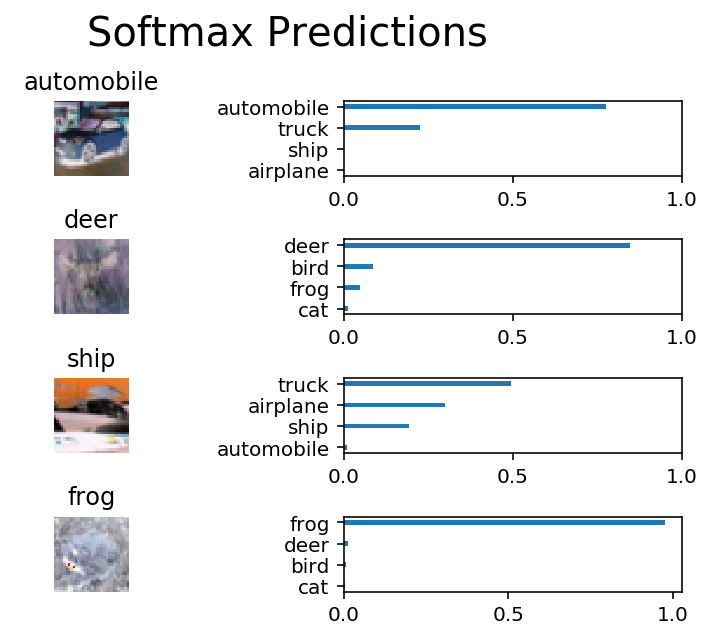

In [32]:
#Calling the function
test_classification_model()

## By applying simple CNN model on a CIFAR-10 dataset having more than 50000 images, we are able to achive accuracy of more than 60% which is quite good.

## Image Classification using Keras

In this project, you'll classify images from the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). The dataset consists of airplanes, dogs, cats, and other objects. 

You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded. You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers. At the end, you'll get to see your neural network's predictions on the sample images.

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten,MaxPooling2D,Dropout
from keras.optimizers import SGD
# Loading the CIFAR-10 datasets
from keras.datasets import cifar10
import tensorflow as tf

C:\Users\skhaldar\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Data

CIFAR-10 is an established computer-vision dataset used for object recognition. 

It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.


In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 191s 1us/step


In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


In [4]:
# Transofrm them to a float32 type
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the input 
X_train /= 255
X_test /= 255

### Explore the Data

The dataset is broken into batches to prevent your machine from running out of memory. The CIFAR-10 dataset consists of 5 batches, named data_batch_1, data_batch_2, etc.. Each batch contains the labels and images that are one of the following:
#### •airplane *automobile
#### •bird
#### •cat
#### •deer
#### •dog
#### •frog
#### •horse
#### •ship
#### •truck 

Understanding a dataset is part of making predictions on the data. Play around with the code cell below by changing the batch_id and sample_id. The batch_id is the id for a batch (1-5). 

The sample_id is the id for a image and label pair in the batch. Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?". Answers to questions like these will help you preprocess the data and end up with better predictions.


In [5]:
labels = [ 'airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck']
for i in range(len(labels)):
  print(str(i)+" : "+labels[i])

0 : airplane
1 : automobile
2 : bird
3 : cat
4 : deer
5 : dog
6 : frog
7 : horse
8 : ship
9 : truck


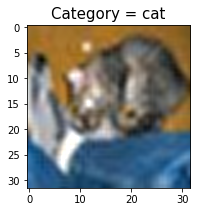

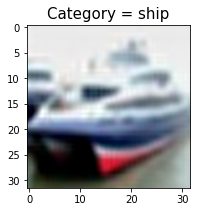

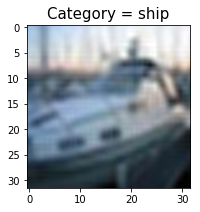

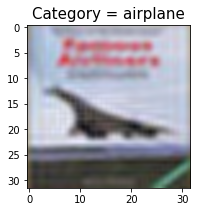

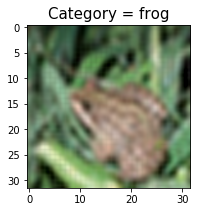

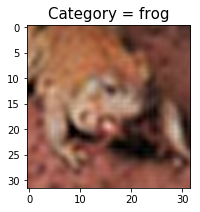

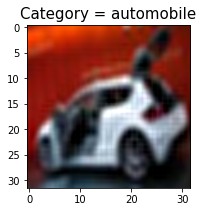

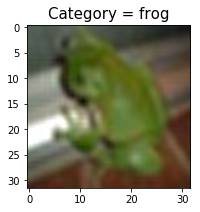

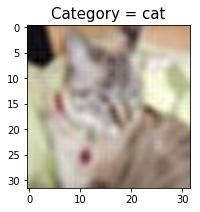

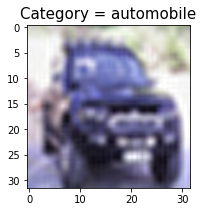

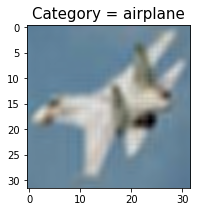

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import re
%matplotlib inline
def  plot_CIFAR(ind):
    arr = X_test[ind]
    
 
    img = arr
    title = labels[y_test[ind][0]]
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    ax.imshow(img,interpolation='sinc')
    ax.set_title('Category = '+ title,fontsize =15)
    
for i in range(11) :
    plot_CIFAR(i)

In [7]:
# Convert and pre-processing
from keras.utils import np_utils
#one hot encoding of target labels
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [8]:
X_train.shape[1:]

(32, 32, 3)

In [9]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',activation='relu',input_shape=X_train.shape[1:]))
#model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
#add output layer
model.add(Dense(10,activation=tf.nn.softmax))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Dense
from keras.utils.data_utils import Sequence
#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)
batch_size =128
epochs = 10
# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(X_train, y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=400,
                    epochs=epochs,
                    validation_data=(X_test, y_test))

Epoch 1/10
400/400 [==============================] - 394s 984ms/step - loss: 1.4391 - acc: 0.4777 - val_loss: 1.2149 - val_acc: 0.5620
Epoch 2/10
400/400 [==============================] - 389s 973ms/step - loss: 1.2281 - acc: 0.5605 - val_loss: 1.0960 - val_acc: 0.6094
Epoch 3/10
400/400 [==============================] - 414s 1s/step - loss: 1.1160 - acc: 0.6044 - val_loss: 0.9781 - val_acc: 0.6517
Epoch 4/10
400/400 [==============================] - 419s 1s/step - loss: 1.0348 - acc: 0.6329 - val_loss: 0.8942 - val_acc: 0.6861
Epoch 5/10
400/400 [==============================] - 424s 1s/step - loss: 0.9737 - acc: 0.6561 - val_loss: 0.8368 - val_acc: 0.7014
Epoch 6/10
400/400 [==============================] - 403s 1s/step - loss: 0.9277 - acc: 0.6731 - val_loss: 0.8589 - val_acc: 0.7025
Epoch 7/10
400/400 [==============================] - 405s 1s/step - loss: 0.8869 - acc: 0.6896 - val_loss: 0.7438 - val_acc: 0.7393
Epoch 8/10
400/400 [==============================] - 421s 1s/s

In [18]:
Y_pred = model.predict(X_test)

In [19]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [20]:
Y_pred

array([[1.3203228e-04, 4.7004371e-04, 4.7917280e-04, ..., 1.9113474e-04,
        5.7422044e-04, 2.2509796e-04],
       [1.8459721e-06, 1.2196735e-02, 2.2975056e-11, ..., 2.4409609e-15,
        9.8779988e-01, 1.5217519e-06],
       [1.4910368e-02, 9.8399237e-02, 6.1222556e-04, ..., 1.5364165e-05,
        8.7880874e-01, 6.7769228e-03],
       ...,
       [1.4459103e-04, 8.8208335e-06, 1.9193474e-02, ..., 1.2561563e-01,
        5.6895229e-04, 7.3853254e-05],
       [2.1659811e-01, 5.6215954e-01, 4.2901050e-02, ..., 1.1053701e-03,
        2.6819909e-03, 4.3824594e-03],
       [8.0255859e-08, 6.0878533e-09, 8.1400613e-06, ..., 9.9076462e-01,
        2.9972880e-09, 1.6848585e-08]], dtype=float32)

In [21]:
y_pred = []
for i in Y_pred:
    j = []
    for k in i:
        if k > 0.5:
            j.append(1)
        else:
            j.append(0)
    y_pred.append(j)

### Retrieve Predictions

In [22]:
y_pred

[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0,

#### Evaluate the predictions

In [23]:
labels[np.argmax(y_test[0])]

'cat'

In [24]:
labels[np.argmax(y_pred[0])]

'cat'

In [25]:
labels[np.argmax(y_test[1])]

'ship'

In [33]:
labels[np.argmax(y_pred[7])]

'airplane'

In [34]:
labels[np.argmax(y_pred[1])]

'ship'

In [27]:
actual = []
for i in y_test:
    actual.append(np.argmax(i))

In [28]:
pred = []
for i in y_pred:
    pred.append(np.argmax(i))

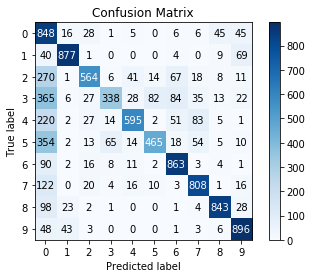

In [31]:
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(actual,pred)

In [32]:
import sklearn
print("Accuracy of  the model is : ",sklearn.metrics.accuracy_score(actual,pred)*100,'%')

Accuracy of  the model is :  70.97 %


### Why 50-70% Accuracy?

You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN. Pure guessing would get you 10% accuracy. However, you might notice people are getting scores well above 70%. That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
